In [3]:
import numpy as np
import torch
torch.set_printoptions(sci_mode=False)
import networkx as nx
from netAPI import adjacency_matrix
from GNNAPI import buildVNNConfig

#from NetRepLearnerV2 import NetGNNAttRepr
# from NetRepLearnerV2 import NetReprLearning
import pandas as pd
from netAPI import pickleLoad, pickleDump
# from GNNAPI import nnSquare, nnExp
from GNNAPI import VNN_MLP
from GNNAPI import GNN_VNN_Layer
from GNNAPI import buildLaplacian
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist,pdist
import scipy.stats
# from GNNAPI import DirectTensor
import scipy.optimize
import scipy.stats as stats

from netAPI import loadNetworkMat
from netAPI import adjacency_matrix
from GNNAPI import GNN_VNN_Layer
from GNNAPI import VNN_MLP
from GNNAPI import VNNDefaultConfig
from GNNAPI import buildLaplacian
from GNNAPI import buildVNNConfig
# from GNNAPI import matrixNormalize
# from GNNAPI import GNN_VNN_Multiclass_Layer
from GNNAPI import NNmodel
from GNNAPI import dmerge
import time

import geopandas as gpd
from shapely.geometry import Point
from esda.moran import Moran
from esda.geary import Geary
import libpysal

import numpy as np
from scipy.stats import truncnorm
from scipy.optimize import fmin_slsqp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/home/mingyi/anaconda3/envs/gnn/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [17]:
class NNmodel(nn.Module): #NN model class template
    iteratelearning : 0
    reloadBestAfterEpochs: 0
    brokenGradientReload: False
    #def __init__(self):
    def forward(self, X): #abstract method forward
        pass

    def loss(self, Y = None, Ytrue = None): #abstract method loss between the recent output of forward and the true Y (if supervised)
        return torch.mean(torch.square(Y - Ytrue)) #default MSE loss

    def params(self): #abstract method for the set of trainable parameters
        return None

    def out_params(self): #abstract method for getting the set of parameters for saving/passing the model setpu
        return None

    def init_params(self, params): #initialize parameters manually or through pre-saved model configuration
        pass

    def batch(self, X, Y, batchsize = 0): #default batching method; could be overriden
        # mh edited for situation batchsize = 0
        print('in batch function')
        batchind = range(X.shape[0])
        if batchsize > 0:
            batchind = np.random.choice(batchind, batchsize) #batching
            return X[batchind, :], Y[batchind, :]
        else:
            print('return X,Y')
            return X,Y

    #handling fit events
    # def fitInitHandle(self):
    #     print("Optimization starting")

    def fitEpochHandle(self):
            print('Epoch: {:04d} of {:04d}'.format(self.fitstate['epoch'] + 1, self.fitstate['n_epochs']), 'batch loss: {:.8f}'.format(self.fitstate['loss']), 'full loss: {:.8f}'.format(self.fitstate['full_loss']),
                  'best loss: {:.8f}'.format(self.fitstate['best_loss']),
                  'time elapsed: {:.4f}s'.format(time.time() - self.fitstate['start_time']))

    def fitFinalHandle(self):
        if not(self.fitstate.get('best_params') is None): #initialize with best parameters found so far
            self.init_params(self.fitstate.get('best_params'))
        print("Optimization Finished with loss", self.fitstate['final_loss'])
        print("Total time elapsed: {:.4f}s".format(time.time() - self.fitstate['start_time']))

    def bestUpdateHandle(self):
        self.fitstate['best_params'] = self.out_params()

    def epochsNoBestHandle(self):
        self.fitstate['iterations_nobest'] = self.fitstate.get('iterations_nobest', 0) + 1
        if (self.reloadBestAfterEpochs > 0) & (self.fitstate['iterations_nobest'] >= self.reloadBestAfterEpochs) & self.brokenGradientReload: #restore previous best setup after a series of unsuccesful epochs
            if not(self.fitstate.get('best_params') is None):
                self.init_params(self.fitstate.get('best_params'))
                self.fitstate['iterations_nobest'] = 0
                self.brokenGradientReload = False


    def initoptimizer(self, lr): #initialize optimizer with model's trainable parameters and selected learning rate
        params = self.params()
        if isinstance(lr, list): #set learning rates
            for p in range(len(lr)):
                if p < len(params):
                    params[p]['lr'] = lr[p]
            lr = lr[-1]
        elif isinstance(lr, dict): #problematic
            for p in range(len(params)):
                k = list(params[p].keys())[0]
                if k in lr.keys():
                    params[p]['lr'] = lr[k]
            lr = lr['default']

        return optim.Adam(params, lr=lr)

    #model fit - generic approach, to be adjusted with overloaded batching and event handlers
    def fit(self,OD=None, X = None, Ytrue = None, n_epochs = 1000, lr = 0.005, batchsize = 0, interim_output_freq = 200, full_loss_freq = 20, SEED = 1): #torch fit
        if not(X is None):
            X = torch.FloatTensor(X)
        if not(Ytrue is None):
            pass
            # Ytrue = torch.FloatTensor(Ytrue)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        start_time = time.time()
        self.fitstate = {'epoch' : -1}

        optimizer = self.initoptimizer(lr)

        best_loss = np.Inf
        # self.fitInitHandle()

        t_1run = time.time()

        self.fitstate = {'epoch': 0, 'n_epochs': n_epochs, 'loss': None, 'full_loss': None, 'start_time': start_time, 'Y': None, 'Y_true': Ytrue,'loss_list':[]}
        # print('X.shape in GNNAPI',X.shape)
        for epoch in range(n_epochs):
            self.fitstate['epoch'] = epoch
            # mh: commented out as batch function keeps return none
            # X_b, Ytrue_b = self.batch(X, Ytrue, batchsize)
            X_b, Ytrue_b = X, Ytrue
            # print('X.shape in GNNAPI fit',X.shape)
            # print('X_b.shape',X_b.shape)

            if self.iteratelearning:
                optimizer = self.initoptimizer(lr)
            optimizer.zero_grad()
            Y = self.forward(X = X_b)
            self.fitstate['Y'] = Y
            loss = self.loss(Y, Ytrue_b)
            loss.backward()
            optimizer.step()
            self.fitstate['loss'] = loss.item()
            self.fitstate['loss_list'] += [loss.item()]
            if full_loss_freq > 0 and epoch % full_loss_freq == 0: #store best states so far
                if batchsize > 0:
                    Y = self.forward(X)
                    full_loss = self.loss(Y, Ytrue)
                else:
                    full_loss = loss

                self.fitstate['full_loss'] = full_loss.item()
                
                if epoch == 0 or full_loss < best_loss:
                    best_loss = full_loss
                    self.fitstate['best_loss'] = best_loss.item()
                    self.fitstate['epoch_best'] = epoch
                    self.bestUpdateHandle()
                else:
                    self.epochsNoBestHandle()

            # if epoch % interim_output_freq == 0 or epoch == n_epochs - 1:
            #     self.fitEpochHandle()

        self.fitstate['final_loss'] = best_loss.item()
        # self.fitFinalHandle()
        return self.fitstate['final_loss']

    def evaluate(self, X = None, Ytrue = None): #evaluate model performance on the new data
        Y = self.forward(X)
        self.fitstate = {'final_loss' : self.loss(Y, Ytrue).item(), 'start_time' : time.time()}
        self.fitFinalHandle()

In [18]:
class NetReprLearning(NNmodel):
    def __init__(self, A,fts, GNNConfigs, VNNConfig, train = None, directembedding = False):
        super().__init__()
        self.N = A.shape[0]
        self.fullA = A
#         self.fts = fts.to(torch.device("cuda"))
        self.directembedding = directembedding
        if train is None:
            train = np.ones(self.N) == 1
        self.A = A * train
        self.train = torch.FloatTensor(train) #train
        self.initNNs(fts,GNNConfigs, VNNConfig)
    def initNNs(self,fts, GNNConfigs, VNNConfig):
        L = torch.FloatTensor(buildLaplacian(self.A))
        L = L.to(torch.device("cuda"))

        self.embed_dim = GNNConfigs[-1]['out_features']
        # mh edited, previous infeautre for GNN layer was N nodes as X is none
        
        featuredims = [self.N] + [v['out_features'] for v in GNNConfigs]
        # mh: v['out_features'] for v in GNNConfigs: self.N, ed
#         featuredims = [fts.shape[1]] + [v['out_features'] for v in GNNConfigs]
        print('featuredims',featuredims)
        self.embed_dim = featuredims[-1]
        if self.directembedding:
            self.GNNLayers = [DirectTensor((self.N, self.embed_dim))]
            self.GNNLayerNum = 1
        else:
            self.GNNLayerNum = len(GNNConfigs)
            self.GNNLayers = [GNN_VNN_Layer([L], in_features = featuredims[i], 
                            VNNConfig = GNNConfigs[i]) for i in range(self.GNNLayerNum)]
        VNNConfig.update({'in_features' : 2 * self.embed_dim+1, 'out_features': 1})
        self.OutVNN = VNN_MLP(VNNConfig = VNNConfig)

    def embed(self,X):
        if X is None:
            X = torch.FloatTensor(np.eye(self.N))
#         print('X.shape',X.shape)
        X = X.to(torch.device("cuda"))
        for i in range(self.GNNLayerNum):
            X = self.GNNLayers[i].forward(X)
#             print(X)
        self.nodeEmbed = X
        return X    

    def forward(self, X):
       
        E = self.embed(X)
        PE = torch.cat([E.repeat(self.N, 1), E.repeat(1, self.N).reshape((-1, E.shape[1]))], dim = 1)
        y = self.OutVNN.forward(PE).reshape((self.N, self.N))
        return y

    def params(self):
        return self.OutVNN.params() + sum([self.GNNLayers[i].params() for i in range(self.GNNLayerNum)], []) 
    
    def batch(self, X, Y, batchsize = 0): #default batching method; could be overriden
        # mh edited for situation batchsize = 0
        print('in batch function')
        batchind = range(X.shape[0])
        if batchsize > 0:
            batchind = np.random.choice(batchind, batchsize) #batching
            return X[batchind, :], Y[batchind, :]
        else:
            print('return X,Y')
            return X,Y

    def fitEpochHandle(self):
        #BCE = netloss(fitstate['Ytrue'], fitstate['Ytrue'], self.train_, style = 'BCE')
        #MSE = netloss(itstate['Ytrue'], fitstate['Ytrue'], self.train_, style = 'MSE')
        #acc = netloss(itstate['Ytrue'], fitstate['Ytrue'], self.train_, style = 'acc')

        print('Epoch: {:04d} of {:04d}'.format(self.fitstate['epoch'] + 1, self.fitstate['n_epochs']), 'batch loss: {:.8f}'.format(self.fitstate['loss']), 'full loss: {:.8f}'.format(self.fitstate['full_loss']),
              'best loss: {:.8f}'.format(self.fitstate['best_loss']),
              'time elapsed: {:.4f}s'.format(time.time() - self.fitstate['start_time']), self.param_checksum(previous = self.init_checksum,
                cumulative = True))
    def loss(self, Y = None, Ytrue = None):
        return netloss(Ytrue, Y, mask = self.train_, style='BCE')


    def fit(self,X, n_epochs = 1000, lr = 0.005, SEED = 1, batchsize = 0, interim_output_freq = 200):
        self.train_ = torch.FloatTensor(self.train)
        self.Y = torch.FloatTensor(self.A) * self.train_
        self.Y = self.Y.to(torch.device("cuda"))
        self.train_ = self.train_.to(torch.device("cuda"))
        self.init_checksum = self.out_params()
        self.reloadBestAfterEpochs = 0
        self.iteratelearning = 0
        self.brokenGradientReload = False
        self.fitstate = {}
#         print('X.shape in fit',X.shape)
        #self.cs = copy.deepcopy(self.init_checksum)
        super().fit(X=X, Ytrue = self.Y, n_epochs = n_epochs, lr = lr, SEED = SEED, batchsize = batchsize, interim_output_freq = interim_output_freq)

    def param_checksum(self, previous = {}, cumulative = True):
        return dmerge({'OutVNN': self.OutVNN.param_checksum(previous.get('OutVNN', {}), cumulative)},
                      {'GNNLayer{}'.format(i): self.GNNLayers[i].param_checksum(previous.get('GNNLayer{}'.format(i), {}), cumulative) for i in range(self.GNNLayerNum)})

    def out_params(self):
        return dmerge({'OutVNN': self.OutVNN.out_params()},
                      {'GNNLayer{}'.format(i): self.GNNLayers[i].out_params() for i in range(self.GNNLayerNum)})



In [ ]:
class GMLearning(NetReprLearning): #mobility model learning class

    def initNNs(self,fts, GNNConfigs, VNNConfig):
        torch.manual_seed(0)
        self.embed_dim = GNNConfigs['out_features']
        # mh edited, previous infeautre for GNN layer was N nodes as X is none
        
        # mh: v['out_features'] for v in GNNConfigs: self.N, ed
        featuredims = [fts.shape[1]] + [GNNConfigs['out_features']]
        print('featuredims',featuredims)
        self.embed_dim = featuredims[-1]
        self.GNNLayerNum = len(GNNConfigs)
#         self.GNNLayers = [GNN_VNN_Layer(in_features = featuredims[i], 
#                         VNNConfig = GNNConfigs[i]) for i in range(self.GNNLayerNum)]
        self.num_heads = GNNConfigs['transformer_num_heads']
        self.gat_num_heads = GNNConfigs['gat_num_heads']
        self.input_dim = featuredims[0]
        self.attention_out_dim = GNNConfigs['attention_out_dim']
        self.edge_dim = GNNConfigs['edge_dim']
        

        self.shortcut1 = nn.Linear(self.input_dim, GNNConfigs['layer_dims'][0]* self.gat_num_heads)
        self.shortcut2 = nn.Linear(GNNConfigs['layer_dims'][0]* self.gat_num_heads,
                                   GNNConfigs['out_features'])
        
        self.in_conv = GATConv(self.input_dim, GNNConfigs['layer_dims'][0],edge_dim=self.edge_dim,
                               heads=self.gat_num_heads,concat=True)
#         Hidden layers

        self.hidden_layers = torch.nn.ModuleList()
        for i,hidden in enumerate(GNNConfigs['layer_dims']):
            if i + 1 < len(GNNConfigs['layer_dims']):
                self.hidden_layers.append(
                    GATConv(hidden * self.gat_num_heads, GNNConfigs['layer_dims'][i+1], 
                            heads=self.gat_num_heads,
                             concat=True)
                )
        
        # Output layer
        self.out_conv = GATConv(GNNConfigs['layer_dims'][-1] * self.gat_num_heads, 
                                GNNConfigs['out_features'], heads=self.gat_num_heads, 
                                concat=False)

        # Hidden layers
       
       
        self.OutMLP = nn.Linear(GNNConfigs['out_features']*2,1)

        # Linear layers for query, key, and value projections
        self.query_projection = nn.Parameter(torch.randn(self.embed_dim,self.attention_out_dim,device='cuda'))                                                                                             
        self.key_projection = nn.Parameter(torch.randn(self.embed_dim,self.attention_out_dim,device='cuda'))
        self.expo = nn.Parameter(torch.randn(1,1,device='cuda'))
        
        
        

    def forward(self,A, X,OD,between_fts): #feed-forward computation - embedding and the attractivity scores
        wout = OD.sum(axis = 1,keepdims=True)
        win = OD.sum(axis = 0,keepdims=True)
#         OD[OD==0] = 0.1
#         win[win==0] = 0.2
        W = wout * win / win.sum()
        #         print(type(wout),type(win),type(W))

        wout = wout.to(torch.device("cuda"))
        self.win = win.to(torch.device("cuda"))
        W = W.to(torch.device("cuda"))
#         X = X.to(torch.device("cuda"))
        if self.model == 'p':
            rows = []
            cols = []
            for i in range(OD.shape[0]):
                for j in range(OD.shape[0]):
                    if i != j:
                        rows.append(i)
                        cols.append(j)
            edge_index = torch.tensor([rows, cols], dtype=torch.long)
            edge_index = edge_index.to(torch.device("cuda"))
#             print(X.device,edge_index.device,between_fts.device)
            E = self.in_conv(X, edge_index,edge_attr=between_fts)

            E += self.shortcut1(X)
            E = nn.Sigmoid()(E)
#             print('----------ReLU-----------------')
#             print(E)


            for layer in self.hidden_layers:
                E = layer(E, edge_index)+E
                E = nn.Sigmoid()(E)

            E = self.out_conv(E, edge_index)+self.shortcut2(E)

            E = nn.Sigmoid()(E)
        if self.attention:
            seq_len, input_dim = E.size()

            query = torch.matmul(E,self.query_projection)
#             print('==============query==================')
#             print(query)
            key =torch.matmul(E,self.key_projection)
#             print('==============key===================')
#             print(key)
            # Reshape the query, key, and value tensors to enable multi-head attention
            query = query.view(seq_len, self.num_heads,self.attention_out_dim // self.num_heads).permute(1, 0, 2)
            key = key.view(seq_len, self.num_heads, self.attention_out_dim  // self.num_heads).permute(1, 0, 2)

            # Compute the dot product attention scores
            scores = torch.matmul(query, key.permute(0, 2, 1))

            scores = scores / torch.sqrt(torch.tensor(input_dim*2 / self.num_heads, dtype=torch.float32))
            attention_weights = torch.mean(scores,axis=0)
            attention_weights = nn.ReLU()(attention_weights)
            y = attention_weights
        elif self.VNNattraction:
            edge_index = list(zip(sorted(list(range(E.shape[0]))*E.shape[0]),
                                      list(range(E.shape[0]))*E.shape[0]))
            edge_index = np.array(edge_index)

            PE_ = torch.concat([E[edge_index[:,0]],E[edge_index[:,1]]],axis=1)
#             print(E)

            batch_size = 10000
            num_batches = PE_.shape[0] // batch_size
            for i in range(num_batches+1):
                # Generate mini-batch indices
                start_idx = i * batch_size
                end_idx = (i + 1) * batch_size
                if end_idx <= PE_.shape[0]:
                    pass
                else:
                    end_idx = PE_.shape[0]+1

                # Extract mini-batch data and labels
                PE_batch = PE_[start_idx:end_idx]
                if i == 0:
                    y = self.OutMLP.forward(PE_batch)
                    y = nn.Sigmoid()(y)
                    y = F.dropout(y,p=0.2)
                else:
                    y_temp = self.OutMLP.forward(PE_batch)
                    y_temp = nn.Sigmoid()(y_temp)
                    y_temp = F.dropout(y_temp,p=0.2)
                    y = torch.concat([y,y_temp])
            y = y.view(E.shape[0], E.shape[0])
            
        if self.model == 'p':
#             A_tensor = torch.FloatTensor(A)
#             A_tensor = A.to(torch.device("cuda"))
#             print(y)
            y = wout * (self.win  * torch.exp(-y*A)) /\
                        (self.win  * torch.exp(-y*A)).sum(axis=1,keepdims=True)
  


            
        elif self.model == 'g':
            y = wout * (self.win * torch.exp(self.expo*A) /\
                        (self.win  * torch.exp(self.expo*A)).sum(axis=1,keepdims=True))


    
        return y

    def logMSE(self, Y, Ytrue): #log MSE loss for the unconstrained model
#         print(Y.device,Ytrue.device,self.W.device,mask.device)
        
        loss_ =  ((torch.log(Ytrue + 1) -\
                                   torch.log(Y + 1)) ** 2).mean()
#         loss_ = (torch.mul(mask , (Ytrue -Y ) ** 2)).sum() / mask.sum()
        return loss_
    def MSE(self, Y, Ytrue): #log MSE loss for the unconstrained model
#         print(Y.device,Ytrue.device,self.W.device,mask.device)
        loss_ =  ((Ytrue - Y ) ** 2).mean()
#         loss_ = (torch.mul(mask , (Ytrue -Y ) ** 2)).sum() / mask.sum()
        return loss_
    def LL(self, p, Ytrue): #log MSE loss for the unconstrained model
        loss_ =  -(Ytrue*torch.log(p)).mean()
        return loss_

    def KL(self, Y, Ytrue): #log MSE loss for the unconstrained model

        loss_ =  (Ytrue*torch.log((Ytrue+1e-8)/(Y+1e-8))).mean()

#         print(loss_)
        return loss_

    def RAE(self, Y, Ytrue): #log MSE loss for the unconstrained model
#         print(Y.device,Ytrue.device,self.W.device,mask.device)
        ybar = Ytrue.mean()
        loss_ =  (torch.absolute(Ytrue - Y )).sum()/(torch.absolute(Ytrue - ybar )).sum()
#         loss_ = (torch.mul(mask , (Ytrue -Y ) ** 2)).sum() / mask.sum()
        return loss_
    def chi(self, Y, Ytrue): #log MSE loss for the unconstrained model

        loss_ =  (((Ytrue - Y )**2)/(Y+1e-8)).mean()
        return loss_

    def loss(self, Y = None, Ytrue = None): #compute loss

        return self.KL(Y,Ytrue)

    def initEmbed(self, x): #initialize node embedding with some initial coordinates
        self.GNNLayers[0].init_params({'X': x})

# mh edited for mask by nodes
def getTrainTestbyNodes(A, train_p = 0.7, seed = 1): #train-test split of the network edges
    np.random.seed(seed)
    number = np.random.uniform(size = A.shape[0])

    valid = number < (1-train_p)**2
    train = np.array([True if i < train_p and i >= (1-train_p)**2 else False for i in number ])
    test = number > train_p
    

    return train,valid, test

def read_area_from_ct(state,nodes):
    ct_map = gpd.read_file('LEHD/'+state+'.zip')
    ct_map['GEOID'] = ct_map['GEOID'].astype(int)
    ct_map = ct_map.set_index('GEOID')
    ct_map = ct_map.loc[nodes]

    return ct_map.to_crs('ESRI:102008').geometry.area.values

def read_location_from_ct(state,nodes):
    ct_map = gpd.read_file('LEHD/'+state+'.zip')
    ct_map['GEOID'] = ct_map['GEOID'].astype(int)
    ct_map = ct_map.set_index('GEOID')
    ct_map = ct_map.loc[sorted(list(nodes))]
    ct_map = ct_map.to_crs('epsg:4326')
    return np.array(list(zip(ct_map.geometry.centroid.x,
                    ct_map.geometry.centroid.y)))

In [24]:
class GMLearning(NetReprLearning): #mobility model learning class

    lossType = 'binB1' #type of the loss function/model to use - logMSE for the unconstrained model or binomial likelihood
    VNNattraction = False #use VNN to compute relative attraction between pairs of nodes based on emebdding; alternatively use exp(-dist(x_a,x_b))

    def initNNs(self,fts, GNNConfigs, VNNConfig): #initialize the model components
        L = torch.FloatTensor(buildLaplacian(self.A)).to(torch.device("cuda"))
        self.embed_dim = GNNConfigs[-1]['out_features']
        featuredims = [self.N] + [v['out_features'] for v in GNNConfigs]
        self.embed_dim = featuredims[-1]
        self.gamma = 1

        if self.directembedding:
            self.GNNLayers = [DirectTensor((self.N, self.embed_dim))]
            self.GNNLayerNum = 1
        else:
            self.GNNLayerNum = len(GNNConfigs)
            self.GNNLayers = [GNN_VNN_Layer([L], in_features = featuredims[i], VNNConfig = GNNConfigs[i]) for i in range(self.GNNLayerNum)]
#             print('featuredims',featuredims)

        VNNConfig.update({'in_features' : 1, 'out_features': 1})
        self.OutVNN = VNN_MLP(VNNConfig = VNNConfig)
        

    def initW(self, A): #initialize the incoming/outgoing mobility flows
        self.wout = A.sum(axis = 1)
        self.win = A.sum(axis = 0)

        self.Win = torch.FloatTensor(np.ones((len(self.win), 1)) * self.win)
        self.W = torch.FloatTensor(self.wout.reshape((-1, 1)) * self.win / self.win.sum())
        self.W = self.W.to(torch.device("cuda"))
        self.Win = self.Win.to(torch.device("cuda"))
        #self.eps = torch.FloatTensor(1)

    def forward(self, X): #feed-forward computation - embedding and the attractivity scores
        E = self.embed(X)
#         print('X.device',X.device)
        PE = torch.cat([E.repeat(self.N, 1), E.repeat(1, self.N).reshape((-1, E.shape[1]))], dim = 1)
        if self.VNNattraction:
            PE_ = torch.square(PE[:, :E.shape[1]] - PE[:, E.shape[1]:]).sum(dim = 1).reshape((-1, 1))
            y = self.OutVNN.forward(PE_).reshape((self.N, self.N))
        else:
            #y = torch.nn.CosineSimilarity(dim = 1)(PE[:, :E.shape[1]], PE[:, E.shape[1]:]).reshape((self.N, self.N))
            y = torch.exp(- self.gamma * torch.square(PE[:, :E.shape[1]] - PE[:, E.shape[1]:]).sum(dim = 1)).reshape((self.N, self.N)) #torch.sqrt
#         print('y.device',y.device)
        return y

    def logMSE(self, Y, Ytrue, mask): #log MSE loss for the unconstrained model

#         print(Y.device,Ytrue.device,self.W.device,mask.device)
        loss_ = (torch.mul(mask , (torch.log(Ytrue + 1) -\
                                   torch.log(torch.mul(self.W, Y) + 1)) ** 2)).sum() / mask.sum()
        
        return loss_

    def binomialB1(self, Y, Ytrue, mask): #binomial likelihood loss for the B1 model
#         Ytrue = Ytrue.to(torch.device("cuda"))
#         Y = Y.to(torch.device("cuda"))
#         print(Y.device,Ytrue.device,self.W.device)
        RM = torch.mul(Y, self.Win)
        #TM = RM.sum(dim = 1).reshape((-1, 1))
        TM = torch.mul(RM, mask).sum(dim = 1).reshape((-1, 1))
        Tm = 1 #Tm = mask.sum(dim = 1).reshape((-1, 1))
        PM = torch.div(RM , TM / Tm)
        LL = - torch.mul(mask, torch.mul(Ytrue, torch.log(PM))).sum() / torch.mul(mask, Ytrue).sum()
        return LL

    def loss(self, Y = None, Ytrue = None): #compute loss
        return self.logMSE(Y = Y, Ytrue = Ytrue, mask = self.train_) if self.lossType == 'logMSE' else self.binomialB1(Y = Y, Ytrue = Ytrue, mask = self.train_)

    def evaluate(self,X, mask = None, baseline = False): #evaluate model performance on a given sample of edges (mask); baseline will replace the embedding-based attraction Y with a null model Y = 1
        if mask is None:
            mask = np.ones(self.A.shape)
        mask = torch.FloatTensor(mask)
        mask = mask.to(torch.device("cuda"))
        Ytrue = torch.FloatTensor(self.fullA).to(torch.device("cuda"))
        # mh write if X is not none here
#         X = torch.FloatTensor(X).to(torch.device("cuda"))
        if baseline:
            Y = Ytrue * 0 + 1
            Y = Y.to(torch.device("cuda"))
        else:
#             print('X.device',X.device)
            Y = self.forward(X = X)
#             print('Y.device',Y.device)
        return self.logMSE(Y = Y, Ytrue = Ytrue, mask = mask).item() if self.lossType == 'logMSE' else self.binomialB1(Y = Y, Ytrue = Ytrue, mask = mask).item()

    def initEmbed(self, x): #initialize node embedding with some initial coordinates
        self.GNNLayers[0].init_params({'X': x})

    def fitGamma(self, mask = None): #fit the exponential attraction parameter gamma
        def assessGamma(gamma):
            self.gamma = gamma
            return self.evaluate(mask = mask)

        #min_gamma = scipy.optimize.minimize_scalar(assessGamma, bounds = (0.01, 100), method='bounded')
        #self.gamma = min_gamma.x

        gammas = 10**np.arange(-2,2.01,0.25)
        ag = [assessGamma(g) for g in gammas]
        self.gamma = gammas[np.argmin(ag)]

def expandToDim(x, d, sigmaScale = 0.1): #expand coordinates to given dimensionality d, adding random coordinates based on the standard deviation of x scaled by sigmaScale
    sigma = (x - x.mean(axis = 0)).std() * sigmaScale
    return np.concatenate([x, np.random.normal(0, sigma, size = (x.shape[0], d - x.shape[1]))], axis = 1) if d > x.shape[1] else x



def getTrainTest(A, train_p = 0.6, excludeDiogonal = True, seed = 1, symmetrize = True): #train-test split of the network edges
    np.random.seed(seed)
    train = np.random.uniform(size = A.shape)
    if symmetrize:
        train = train * np.tril(np.ones(A.shape[0])) + (train * np.tril(np.ones(A.shape[0]), -1)).transpose()
    train = train < train_p
    test = ~ train
    if excludeDiogonal:
        train &= (1 != np.eye(A.shape[0]))
        test &= (1 != np.eye(A.shape[0]))
    return train, test


def dataProcessing(): #process SF data

    #load SF data
    nettable = pd.read_csv(path + '2021od_formatted.csv')
    nodeXY = pd.read_csv(path + 'station_lat_lng.csv')

    nettable = nettable[['O', 'D', 'Volume']].groupby(['O', 'D']).sum(['Volume']).reset_index()

    #create the network
    G = nx.DiGraph()
    for r in nettable.iterrows():
        G.add_edge(r[1]['O'], r[1]['D'], weight = r[1]['Volume'])

    nodexy = {}
    for r in nodeXY.iterrows():
        nodexy[r[1]['station']] = (r[1]['lat'], r[1]['lng'])

        pickleDump(path + 'SFnetwork.pkl', [G, nodexy])

def estimatePointArea(x, nk = 4): #approximate point's neighborhood area based on nk nearest neighbor distances
    d = cdist(x, x)
    d[d==0] = d[d>0].min()
    d.sort(axis = 1)
    d = d[:, 1: (nk + 1)].prod(axis = 1) ** (2/nk)
    return d

def spatialDistribution(xy,pop):
    weights = libpysal.weights.Queen.from_dataframe(gpd.GeoDataFrame(geometry=[Point(i) for i in xy]))  # generate spatial weights (Queen in this case)
    spatial_auto = Geary(pop, weights,permutations=0) 
    gc = spatial_auto.C
    gp = spatial_auto.p_norm

    spatial_auto = Moran(pop, weights,permutations=0) 
    mc = spatial_auto.I
    mp = spatial_auto.p_norm

    return (gc,gp,mc,mp)

def analyzePopDistr(city, pop, job,xy, flows, area = None, graphics = False): #analysis of the population and flow distribution for the city based on initial or fitted node coordinates xy
    def weightedMuStd(x, w):
        mu = np.average(x, weights = w)
        sigma = np.sqrt(np.sum(w * (x - mu)**2) / np.sum(w))
#         x = (x.copy() - mu)/sigma
        xi = np.argsort(x)
        n = len(x)
        # mh: the sum should be weighted as well
        cdf = np.cumsum(w[xi]) / np.sum(w)
        # mh: fit the truncated gaussian distribution
        
        def func(p, cdf,x):
            cdf_norm = truncnorm.cdf(sorted(x), *p)
            dist = np.max(np.abs(cdf - cdf_norm))
            return dist

        def constraint(p, cdf, x):
            a, b, loc, scale = p
            return np.array([a*scale + loc - x.min(), b*scale + loc - x.max()])
        loc_guess = mu
        scale_guess = sigma
        a_guess = (x.min() - mu)/sigma
        b_guess = (x.max() - mu)/sigma
        p0 = [a_guess, b_guess, loc_guess, scale_guess]

        par = fmin_slsqp(func, p0, f_eqcons=constraint,args=(cdf,x),
                          iter=5000)
#         par = fmin_slsqp(func, p0,args=(cdf, x.min(), x.max()),
#                   iter=5000)
        print(p0)
        print(par)
        cdf_norm = truncnorm.cdf(sorted(x), *par)
        p_value = 1 - np.max(np.abs(cdf - cdf_norm))
        
        # par[2] par[3] are mean and std
        return x,cdf,cdf_norm,par[2], par[3], p_value

    if area is None:
        area = estimatePointArea(xy , nk = 3)
        
    
    #log density
    ldens = np.log(pop) - np.log(area)
    x,cdf,cdf_norm,mu, sigma, pv = weightedMuStd(x= ldens, w = pop)
    print('{}, pop_mu = {:.4f}, pop_sigma = {:.4f}, pop_pv = {:.4f}'.format(city, mu, sigma, pv))
    ldens = np.log(job) - np.log(area)
#     x,cdf,cdf_norm,mu, sigma, pv = weightedMuStd(x= ldens, w = job)
#     print('{}, job_mu = {:.4f}, job_sigma = {:.4f}, job_pv = {:.4f}'.format(city, mu, sigma, pv))
    commute_distance = scipy.spatial.distance.cdist(xy,xy)
    commute_distance = commute_distance.flatten()
    x,cdf,cdf_norm,mu, sigma, pv = weightedMuStd(x= commute_distance, w = flows.flatten())
    print('{}, dist_mu = {:.4f}, dist_sigma = {:.4f}, dist_pv = {:.4f}'.format(city, mu, sigma, pv))


    if graphics:
        fig, ax = plt.subplots(1, 1)
        ax.plot(sorted(x),cdf,
                'r-', lw=3, alpha=0.4, label='truncnorm pdf')
        ax.plot(sorted(x), cdf_norm,
                'k--', lw=1, alpha=1.0, label='truncnorm fit')
        # ax.hist(r, bins=15, density=True, histtype='stepfilled', alpha=0.3)
        ax.legend(shadow=True)
        # plt.xlim(xmin, xmax)
        plt.grid(True)

        plt.legend()

def read_area_from_ct(state,nodes):
    ct_map = gpd.read_file('LEHD/'+state+'.zip')
    ct_map['GEOID'] = ct_map['GEOID'].astype(int)
    ct_map = ct_map.set_index('GEOID')
    ct_map = ct_map.loc[list(nodes.keys())]

    return ct_map.to_crs('ESRI:102008').geometry.area.values

def read_location_from_ct(state,nodes):
    ct_map = gpd.read_file('LEHD/'+state+'.zip')
    ct_map['GEOID'] = ct_map['GEOID'].astype(int)
    ct_map = ct_map.set_index('GEOID')
    ct_map = ct_map.loc[list(nodes.keys())]
    ct_map = ct_map.to_crs('epsg:2263')
    return np.array(list(zip(ct_map.geometry.centroid.x,
                    ct_map.geometry.centroid.y)))

In [25]:
nodejob

array([540, 218, 966, ...,  23,   0,   0])

In [26]:
# city = 'Phoenix'
path = 'LEHD/'

cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

for city,state, counties in cities:

    if city == 'SF':
        #dataProcessing()
        [G, nodexy] = pickleLoad(path + 'SFnetwork.pkl')
    else:
        print('processing LEHD')
        LEHD = pickleLoad(path + 'LEHD_cities.pkl')
        nodes = pickleLoad(path + 'LEHD_citynode_attributes.pkl')
        CG = LEHD[city]
        nodes = nodes[city]
        G = nx.DiGraph()
        G.add_weighted_edges_from([(e[0], e[1], e[2]['S000']) for e in CG.edges(data = True)])
        nodepop = dict(G.out_degree(weight="weight"))
        nodepop = np.array([nodepop[n] for n in G.nodes()])
        nodejob = dict(G.in_degree(weight="weight"))
        nodejob = np.array([nodejob[n] for n in G.nodes()])
#         sx = np.cos(np.pi / 180 * 40);
        nodexy = read_location_from_ct(state,nodes)
        nodearea = read_area_from_ct(state,nodes)


    if not(G is None): #if given a graph G, initialize and run the model
        #main parameters
        mainepochs = 1000
        ed = 2 #node embedding dimensionality
        splitSeed = 10
        seed = 2
        directEmebdding = False #learn node embedding directly or through GNNs

        #define the adjacency matrix
        A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())
#         print(A.shape)
#         wind = (A.sum(axis = 0) > 0) & (A.sum(axis = 1) > 0)
#         A = A[wind, :][:, wind] #remove nodes with no incoming or outgoing flows
#         nodepop = nodepop[wind]
#         nodejob = nodejob[wind]
#         nodexy = nodexy[wind]
#         nodearea = nodearea[wind]
        n = A.shape[0]
#         print('processing POI')
#         poi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/rxuy-2muj?method=export&format=GeoJSON')
#         ct_map = gpd.read_file('LEHD/'+state+'.zip')
#         nodefts = POIfts(ct_map,poi,list(G.nodes()))
#         nodefts = nodefts[wind]
#         nodefts = torch.FloatTensor(nodefts).to(torch.device("cuda"))
        nodefts = None
        #some basic stats
        print('City {}, Network of size {}, non-zero edges = {}, unique edge values = {}, avg. edge = {}, total network weight = {}'.format(city, len(G), len(G.edges()), len(np.unique(A)), A.mean(), A.sum()))

        analyzePopDistr(city = city, pop = nodepop,job=nodejob, xy = nodexy, flows = A,area=nodearea) 
        #population and mobility flow distribution analysis

        train, test = getTrainTest(A,train_p= 0.7,  seed = splitSeed) 


        #train-test split for the network edges

        #configurations for the model layers - largely redundant if using directemebdding and exponential attraction
        GNNConfig1 = buildVNNConfig({'out_features': A.shape[0], 'layer_dims':[], 'initSeed': seed}) #A.shape[0]
        GNNConfig2 = buildVNNConfig({'out_features': ed, 'layer_dims':[3 * ed], 'initSeed': seed, 
                                     'actfuncFinal': torch.nn.Sigmoid()}) #2*ed
        VNNConfig = buildVNNConfig({'layer_dims':[4*ed, 2*ed, ed, 3], 'dropout': 0.33, 
                                    'initSeed': seed, 'actfuncFinal': nnExp()}) #nnSquare()
        # input facility_t features here
        NRL = GMLearning(A, nodefts, [GNNConfig1, GNNConfig2], VNNConfig, train, directembedding = directEmebdding) #do we need to eliminate train here?
        NRL.initW(A)
        NRL = NRL.cuda()
        #null model baseline performance
        NRL.lossType = 'logMSE'; print('Baseline logMSE train/test = {}/{}'.\
                                       format(round(NRL.evaluate(X=nodefts,mask = train, baseline = True),3), 
                                            round(NRL.evaluate(X=nodefts,mask = test, baseline = True),3)))
        NRL.lossType = 'binB1'; print('Baseline log-likelihood train/test = {}/{}'.\
                                      format(
                                        round(NRL.evaluate(X=nodefts,mask = train, baseline = True),3), 
                                        round(NRL.evaluate(X=nodefts,mask = test, baseline = True),3)))
        if directEmebdding: #embedding initialization possible only in direct embedding mode
            #singly constrained exponential gravity baseline
            NRL.initEmbed(x = expandToDim(nodexy, d = ed, sigmaScale = 0))
            NRL.lossType = 'binB1'; NRL.fitGamma(mask = train); print('Best gamma = {:.4f}'.format(NRL.gamma))
            NRL.lossType = 'logMSE'; print('Gravity logMSE train/test = {}/{}'.\
                                           format(round(NRL.evaluate(X=nodefts,mask = train, 
                                                                     baseline = False),3), 
                                                  round(NRL.evaluate(X=nodefts,mask = test, 
                                                                     baseline = False),3)))
            NRL.lossType = 'binB1'; print('Gravity log-likelihood train/test = {}/{}'.\
                                          format(
                                                          round(NRL.evaluate(X=nodefts,mask = train, 
                                                                             baseline = False),3), 
                                                          round(NRL.evaluate(X=nodefts,mask = test, 
                                                                             baseline = False),3)))

            #fit the main model
            NRL.initEmbed(x = expandToDim(nodexy, d = ed, sigmaScale = 0.1))
        else:
            NRL.gamma = 10
        lr = [0.001, 0.0003, 0.0003, 0.001]
        #lr = {'OutVNN': 0.0003, 'GNNLayer0': 0.002, 'GNNLayer1': 0.001, 'default': 0.0003}
        NRL.lossType = 'logMSE' 

        NRL.fit(X=nodefts,n_epochs = mainepochs, batchsize = 0, lr = lr, 
                                         interim_output_freq = 50)

        #report the model performance
        NRL.lossType = 'logMSE'; print('Evaluation logMSE train/test = {}/{}'.\
                                       format(round(NRL.evaluate(X=nodefts,mask = train, baseline = False),3), 
                                          round(NRL.evaluate(X=nodefts,mask = test, baseline = False),3)))
        NRL.lossType = 'binB1'; print('Evaluation log-likelihood train/test = {}/{}'.\
                                      format(round(NRL.evaluate(X=nodefts,mask = train, baseline = False),3), 
                                             round(NRL.evaluate(X=nodefts,mask = test, baseline = False),3)))

        nodesDL = NRL.embed(nodefts).cpu().detach().numpy()
        analyzePopDistr(city = city, pop = nodepop,job=nodejob,xy = nodesDL, flows = A)
        print('pop geary C on lat lon and embedding  = {}/{}'.format(
                                round(spatialDistribution(nodexy,nodepop)[0],3),
            round(spatialDistribution(nodesDL,nodepop)[0],3)))

        print('pop moran I on lat lon and embedding  = {}/{}'.format(
            round(spatialDistribution(nodexy,nodepop)[2],3),
                                 round(spatialDistribution(nodesDL,nodepop)[2],3)))

processing LEHD


/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City New York City, Network of size 2157, non-zero edges = 976832, unique edge values = 231, avg. edge = 0.6956067393005576, total network weight = 3236414.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05367270579560812
            Iterations: 39
            Function evaluations: 377
            Gradient evaluations: 39
[-7.55203538765113, 2.523787587537736, -4.982694463902842, 0.9476246084833265]
[-8.72669029  2.75093219 -4.87955905  0.83188812]
New York City, pop_mu = -4.8796, pop_sigma = 0.8319, pop_pv = 0.9463


/tmp/ipykernel_252121/912790454.py:204: RuntimeWarning: divide by zero encountered in log
  ldens = np.log(job) - np.log(area)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07529555839052549
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.6744695693672034, 5.325565260323626, 43814.13298823051, 26165.977447286932]
[-1.67446957e+00  5.32556526e+00  4.38141330e+04  2.61659774e+04]
New York City, dist_mu = 43814.1330, dist_sigma = 26165.9774, dist_pv = 0.9247
Baseline logMSE train/test = 0.164/0.164
Baseline log-likelihood train/test = nan/nan
Evaluation logMSE train/test = 0.128/0.128
Evaluation log-likelihood train/test = nan/nan
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01219833699159439
            Iterations: 20
            Function evaluations: 145
            Gradient evaluations: 20
[-5.337777722332827, 3.14107418714464, 18.079435310769, 1.456311426037228]
[-5.56807338  3.23760973 18.11384997  1.40225906]
New York City, pop_mu = 18.1138, pop_sigma = 1.4023, p

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Los Angeles, Network of size 2341, non-zero edges = 1171362, unique edge values = 246, avg. edge = 0.655203446684577, total network weight = 3590699.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.034087988136439464
            Iterations: 31
            Function evaluations: 242
            Gradient evaluations: 31
[-6.079398619777505, 2.640646313203266, -6.575838520012528, 1.1387424932839159]
[-6.91916446  2.89238672 -6.49609339  1.01206073]
Los Angeles, pop_mu = -6.4961, pop_sigma = 1.0121, pop_pv = 0.9659


/tmp/ipykernel_252121/912790454.py:204: RuntimeWarning: divide by zero encountered in log
  ldens = np.log(job) - np.log(area)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11050217902831333
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.4837171464438028, 7.610445875571048, 97899.6447620481, 65982.68746620308]
[-1.48371715e+00  7.61044588e+00  9.78996448e+04  6.59826875e+04]
Los Angeles, dist_mu = 97899.6448, dist_sigma = 65982.6875, dist_pv = 0.8895
Baseline logMSE train/test = 0.212/0.212
Baseline log-likelihood train/test = nan/nan
Evaluation logMSE train/test = 0.143/0.143
Evaluation log-likelihood train/test = nan/nan
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.014042597852995553
            Iterations: 29
            Function evaluations: 229
            Gradient evaluations: 29
[-5.6037631803835435, 3.3955043584174747, 17.951864158432485, 1.3235133062073317]
[-5.82046348  3.5283814  17.95061768  1.27402374]
Los Angeles, pop_mu = 17.9506, pop_sigma = 1.2740,

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Chicago, Network of size 1318, non-zero edges = 439553, unique edge values = 459, avg. edge = 1.068535118966752, total network weight = 1856178.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0271445132728787
            Iterations: 20
            Function evaluations: 157
            Gradient evaluations: 20
[-3.8920216493962836, 3.0545204578154332, -6.437556999498194, 1.1592976931954067]
[-4.00020871  3.04351019 -6.3761151   1.14330375]
Chicago, pop_mu = -6.3761, pop_sigma = 1.1433, pop_pv = 0.9729


/tmp/ipykernel_252121/912790454.py:204: RuntimeWarning: divide by zero encountered in log
  ldens = np.log(job) - np.log(area)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11194423348632238
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.5016918475269472, 4.076217541315406, 77602.9056732479, 51676.98406370641]
[-1.50169185e+00  4.07621754e+00  7.76029057e+04  5.16769841e+04]
Chicago, dist_mu = 77602.9057, dist_sigma = 51676.9841, dist_pv = 0.8881
Baseline logMSE train/test = 0.254/0.253
Baseline log-likelihood train/test = nan/nan
Evaluation logMSE train/test = 0.172/0.171
Evaluation log-likelihood train/test = nan/nan
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.019024710888997043
            Iterations: 12
            Function evaluations: 88
            Gradient evaluations: 12
[-4.230194987148159, 3.081530307708159, 17.21237592701283, 1.1738051570570998]
[-4.34253613  3.12060253 17.24082787  1.14999081]
Chicago, pop_mu = 17.2408, pop_sigma = 1.1500, pop_pv = 0.

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Houston, Network of size 786, non-zero edges = 290496, unique edge values = 348, avg. edge = 2.5043250522826304, total network weight = 1547162.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.033536741845102316
            Iterations: 15
            Function evaluations: 93
            Gradient evaluations: 15
[-4.234223049491029, 2.326990964054591, -7.197918524691099, 1.125023805149044]
[-4.45174073  2.33668227 -7.12083458  1.08736918]
Houston, pop_mu = -7.1208, pop_sigma = 1.0874, pop_pv = 0.9665
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06603491249649535
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.7233302093567635, 4.473875394382368, 90703.53093203752, 52632.70523522756]
[-1.72333021e+00  4.47387539e+00  9.07035309e+04  5.26327052e+04]
Houston, dist_mu = 90703.5309, dist_sigma = 52632.7052, dist_pv = 0.9340
Baseline logMSE tra

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())
/tmp/ipykernel_252121/912790454.py:204: RuntimeWarning: divide by zero encountered in log
  ldens = np.log(job) - np.log(area)


City Boston, Network of size 520, non-zero edges = 127357, unique edge values = 278, avg. edge = 3.5017566568047336, total network weight = 946875.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.042871227746004714
            Iterations: 13
            Function evaluations: 82
            Gradient evaluations: 13
[-3.132762956824272, 2.3735760611041843, -6.640944438181742, 1.515294393675186]
[-3.09652581  2.18685367 -6.49784491  1.57924008]
Boston, pop_mu = -6.4978, pop_sigma = 1.5792, pop_pv = 0.9571
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.22062739392177744
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.1898750100004236, 4.251416090169434, 57721.102501812944, 48510.223356814924]
[-1.18987501e+00  4.25141609e+00  5.77211025e+04  4.85102234e+04]
Boston, dist_mu = 57721.1025, dist_sigma = 48510.2234, dist_pv = 0.7794
Baseline logMSE trai

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())
/tmp/ipykernel_252121/912790454.py:204: RuntimeWarning: divide by zero encountered in log
  ldens = np.log(job) - np.log(area)


City Phoenix, Network of size 916, non-zero edges = 349894, unique edge values = 226, avg. edge = 2.101198251368204, total network weight = 1763023.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05082157755670619
            Iterations: 26
            Function evaluations: 168
            Gradient evaluations: 26
[-6.294473646950642, 1.9184122987885657, -7.3471611253537805, 1.1869075543758707]
[-7.85175063  2.16406967 -7.17637237  0.97325392]
Phoenix, pop_mu = -7.1764, pop_sigma = 0.9733, pop_pv = 0.9492
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10847160063838568
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.4942810654064016, 7.175767705834124, 98267.89283614336, 65762.65677931033]
[-1.49428107e+00  7.17576771e+00  9.82678928e+04  6.57626568e+04]
Phoenix, dist_mu = 98267.8928, dist_sigma = 65762.6568, dist_pv = 0.8915
Baseline logMSE t

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())
/tmp/ipykernel_252121/912790454.py:204: RuntimeWarning: divide by zero encountered in log
  ldens = np.log(job) - np.log(area)


City Philadelphia, Network of size 384, non-zero edges = 68119, unique edge values = 200, avg. edge = 2.5734931098090277, total network weight = 379477.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03208350955372426
            Iterations: 19
            Function evaluations: 113
            Gradient evaluations: 19
[-6.89824940236513, 2.5349521945912064, -6.3773895439848785, 0.8474578215541881]
[-7.43300692  2.62126386 -6.31331478  0.79510893]
Philadelphia, pop_mu = -6.3133, pop_sigma = 0.7951, pop_pv = 0.9679
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08964379876489881
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.6467292638366091, 4.043681100501697, 32543.818616522836, 19762.701332398185]
[-1.64672926e+00  4.04368110e+00  3.25438186e+04  1.97627013e+04]
Philadelphia, dist_mu = 32543.8186, dist_sigma = 19762.7013, dist_pv = 0.9104
Ba

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())
/tmp/ipykernel_252121/912790454.py:204: RuntimeWarning: divide by zero encountered in log
  ldens = np.log(job) - np.log(area)


City San Antonio, Network of size 366, non-zero edges = 83192, unique edge values = 243, avg. edge = 4.774172116217265, total network weight = 639529.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05968068955186523
            Iterations: 23
            Function evaluations: 198
            Gradient evaluations: 23
[-3.842830846175637, 1.6086499858599552, -7.5984508807585005, 1.1041831776906126]
[-4.12396575  1.31815352 -7.28019342  1.10608248]
San Antonio, pop_mu = -7.2802, pop_sigma = 1.1061, pop_pv = 0.9403
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05493865355779917
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.8268277710002325, 4.634812666781515, 61294.100005901855, 33552.205073137164]
[-1.82682777e+00  4.63481267e+00  6.12941000e+04  3.35522051e+04]
San Antonio, dist_mu = 61294.1000, dist_sigma = 33552.2051, dist_pv = 0.9451
Basel

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())
/tmp/ipykernel_252121/912790454.py:204: RuntimeWarning: divide by zero encountered in log
  ldens = np.log(job) - np.log(area)


City San Diego, Network of size 627, non-zero edges = 180781, unique edge values = 330, avg. edge = 2.9743671924482804, total network weight = 1169310.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05734073947182852
            Iterations: 29
            Function evaluations: 220
            Gradient evaluations: 29
[-5.1028765911297915, 2.1192562120396246, -7.157705884618406, 1.3594180059620478]
[-6.11847606  2.35431318 -7.00482591  1.15875624]
San Diego, pop_mu = -7.0048, pop_sigma = 1.1588, pop_pv = 0.9427
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13922725758387688
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.4274152923623395, 4.4992720911718, 93058.1647177397, 65193.47607922189]
[-1.42741529e+00  4.49927209e+00  9.30581647e+04  6.51934761e+04]
San Diego, dist_mu = 93058.1647, dist_sigma = 65193.4761, dist_pv = 0.8608
Baseline logM

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Dallas, Network of size 529, non-zero edges = 129352, unique edge values = 255, avg. edge = 2.838168817292677, total network weight = 794236.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0270007485795547
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
[-4.3447133428089035, 2.365398765981202, -7.363825854784276, 0.9938163159618447]
[-4.47434945  2.33639485 -7.30069334  0.97913218]
Dallas, pop_mu = -7.3007, pop_sigma = 0.9791, pop_pv = 0.9730
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04901493642530247
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.8435670985170074, 3.908508684490133, 64081.81269347559, 34759.68558183966]
[-1.84356710e+00  3.90850868e+00  6.40818127e+04  3.47596856e+04]
Dallas, dist_mu = 64081.8127, dist_sigma = 34759.6856, dist_pv = 0.9510
Baseline logMSE train/te

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City San Jose, Network of size 372, non-zero edges = 81938, unique edge values = 264, avg. edge = 4.730994912706671, total network weight = 654694.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06771058554746018
            Iterations: 41
            Function evaluations: 282
            Gradient evaluations: 41
[-6.870141525442567, 1.694584477595607, -6.91622539224034, 1.0611390815562327]
[-8.63466118  1.86752279 -6.73414987  0.86537862]
San Jose, pop_mu = -6.7341, pop_sigma = 0.8654, pop_pv = 0.9323
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1594563202173646
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.3060707104632179, 5.229738266459926, 49464.85295382436, 37873.028280590486]
[-1.30607071e+00  5.22973827e+00  4.94648530e+04  3.78730283e+04]
San Jose, dist_mu = 49464.8530, dist_sigma = 37873.0283, dist_pv = 0.8405
Baseline logMSE tra

/tmp/ipykernel_252121/1076787626.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())
/tmp/ipykernel_252121/912790454.py:204: RuntimeWarning: divide by zero encountered in log
  ldens = np.log(job) - np.log(area)


City Austin, Network of size 218, non-zero edges = 34777, unique edge values = 296, avg. edge = 8.63380607692955, total network weight = 410313.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06829024591955944
            Iterations: 21
            Function evaluations: 137
            Gradient evaluations: 21
[-3.8410029115446975, 2.1021801524174157, -7.533669442031963, 1.3098849328536666]
[-4.33424074  2.15344986 -7.36408139  1.19994717]
Austin, pop_mu = -7.3641, pop_sigma = 1.1999, pop_pv = 0.9317
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09762765418382213
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
[-1.5579844797907945, 4.766439719172928, 47505.379503605545, 30491.56144994753]
[-1.55798448e+00  4.76643972e+00  4.75053795e+04  3.04915614e+04]
Austin, dist_mu = 47505.3795, dist_sigma = 30491.5614, dist_pv = 0.9024
Baseline logMSE train/

In [369]:
def analyzePopDistr(city, pop, xy, flows = None, area = None, graphics = False): #analysis of the population and flow distribution for the city based on initial or fitted node coordinates xy
    def weightedMuStd(x, w):
        mu = np.average(x, weights = w)
        sigma = np.sqrt(np.sum(w * (x - mu)**2) / np.sum(w))
#         x = (x.copy() - mu)/sigma
        xi = np.argsort(x)
        n = len(x)
        # mh: the sum should be weighted as well
        cdf = np.cumsum(w[xi]) / np.sum(w)
        # mh: fit the truncated gaussian distribution
        
        def func(p, cdf,x):
            cdf_norm = truncnorm.cdf(sorted(x), *p)
            dist = np.max(np.abs(cdf - cdf_norm))
            return dist

        def constraint(p, cdf, x):
            a, b, loc, scale = p
            return np.array([a*scale + loc - x.min(), b*scale + loc - x.max()])
        loc_guess = mu
        scale_guess = sigma
        a_guess = (x.min() - mu)/sigma
        b_guess = (x.max() - mu)/sigma
        p0 = [a_guess, b_guess, loc_guess, scale_guess]

        par = fmin_slsqp(func, p0, f_eqcons=constraint,args=(cdf,x),
                          iter=5000)
#         par = fmin_slsqp(func, p0,args=(cdf, x.min(), x.max()),
#                   iter=5000)
        print(p0)
        print(par)
        cdf_norm = truncnorm.cdf(sorted(x), *par)
        p_value = 1 - np.max(np.abs(cdf - cdf_norm))

        return x,cdf,cdf_norm,par[2], par[3], p_value

    if area is None:
        area = estimatePointArea(xy , nk = 3)
        
    
    #log density
    ldens = np.log(pop) - np.log(area)
    x,cdf,cdf_norm,pop_mu, pop_sigma, pop_pv = weightedMuStd(x= ldens, w = pop)


    print('{}, pop_mu = {:.4f}, pop_sigma = {:.4f}, pop_pv = {:.4f}'.format(city, pop_mu, pop_sigma, pop_pv))

    if graphics:
            fig, ax = plt.subplots(1, 1)
            ax.plot(sorted(x),cdf,
                    'r-', lw=3, alpha=0.4, label='truncnorm pdf')
            ax.plot(sorted(x), cdf_norm,
                    'k--', lw=1, alpha=1.0, label='truncnorm fit')
            # ax.hist(r, bins=15, density=True, histtype='stepfilled', alpha=0.3)
            ax.legend(shadow=True)
            # plt.xlim(xmin, xmax)
            plt.grid(True)

            plt.legend()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06948183908389621
            Iterations: 17
            Function evaluations: 114
            Gradient evaluations: 17
[-3.9941687815897886, 2.031460535539208, -9.805544339194714, 1.21131987189733]
[-4.30503487  1.93661047 -9.60946332  1.16939746]
Austin, pop_mu = -9.6095, pop_sigma = 1.1694, pop_pv = 0.9305


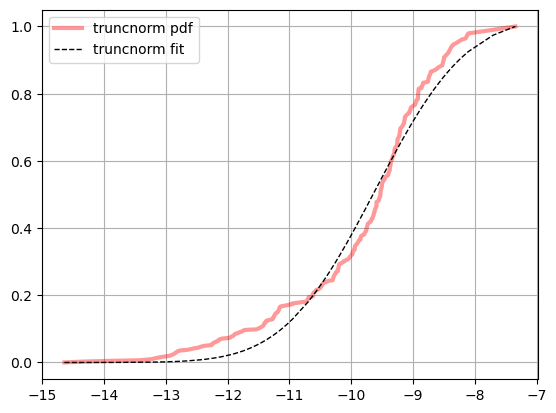

In [370]:
analyzePopDistr(city = city, pop = nodepop,xy = nodexy, flows = A,graphics=True)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02981647089207355
            Iterations: 24
            Function evaluations: 189
            Gradient evaluations: 24
[-4.178890438566647, 2.386123710656552, 16.160565376522655, 1.1192126511937497]
[-4.30252474  2.39555001 16.20327733  1.09697893]
Austin, pop_mu = 16.2033, pop_sigma = 1.0970, pop_pv = 0.9702


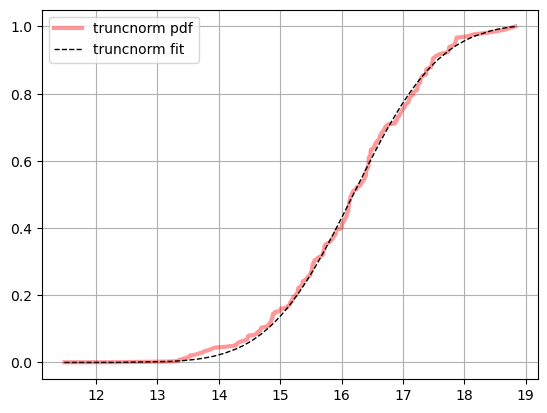

In [371]:
analyzePopDistr(city = city, pop = nodepop,xy = nodesDL, flows = A,graphics=True)

In [5]:
def analyzePopDistr(city, pop, xy, flows = None, area = None, graphics = False): #analysis of the population and flow distribution for the city based on initial or fitted node coordinates xy
    def weightedMuStd(x, w):
        mu = np.average(x, weights = w)
        sigma = np.sqrt(np.sum(w * (x - mu)**2) / np.sum(w))
        x = (x.copy() - mu)/sigma
        xi = np.argsort(x)
        n = len(x)
        # mh: the sum should be weighted as well
        cdf = np.cumsum(w[xi]) / np.sum(w)
        # mh:generate random numbers from normal distribution and calculate its cdf
        # mh: then calculate the max distance between cdf and normal distribution cdf
        cdf_norm = stats.norm.cdf(sorted(x))

        # Calculate the Kolmogorov-Smirnov statistic.
        p_value = 1- np.max(np.abs(cdf - cdf_norm)) #/ np.sqrt(n)

        return mu, sigma, p_value, x,cdf

    if area is None:
        area = estimatePointArea(xy , nk = 3)
        
    
    #log density
    ldens = np.log(pop) - np.log(area)
    pop_mu, pop_sigma, pop_pv, pop_t,pop_cdf = weightedMuStd(x= ldens, w = pop)

    if not(flows is None):
        logflows = True
        d = cdist(xy, xy).flatten()
        f = flows.flatten()
        if logflows:
            f = f[d>0]
            d = np.log(d[d>0])
        dist_mu, dist_sigma, dist_pv,dist_t,dist_cdf = weightedMuStd(x = d, w = f)
    print('{}, pop_mu = {:.4f}, pop_sigma = {:.4f}, pop_pv = {:.4f},\
          flow_mu = {:.4f}, flow_sigma = {:.4f}, flow_pv = {:.4f}'.format(city, pop_mu, pop_sigma, pop_pv,
                                                                          dist_mu, dist_sigma, dist_pv))

    if graphics:
        fig, axes = plt.subplots(3, 2, figsize=(20, 20),dpi=150)
        #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.75)
        axes[0,0].scatter(xy[:, 0], xy[:, 1])
        axes[0,0].set_title(city)
        #axes[0].set_position([0.1, 0.1, 0.5, 0.9])
        axes[1,0].plot(sorted(pop_t), pop_cdf,label='Reality')
        axes[1,0].plot(sorted(pop_t),stats.norm.cdf(sorted(pop_t)),label='Normal')
        axes[1,0].set_title('Population Log-cumulative density distribution')
        

        axes[1,1].hist(pop_t, weights = pop/pop.sum(), bins = round(np.abs(pop_t.min()-pop_t.max())),label='Reality')
        axes[1,1].plot(sorted(pop_t),stats.norm.pdf(sorted(pop_t)),label='Normal')
        axes[1,1].set_title('Population Log-density distribution')
        
        if not(flows is None):
            
            axes[2,0].plot(sorted(dist_t), dist_cdf,label='Reality')
            axes[2,0].plot(sorted(dist_t),stats.norm.cdf(sorted(dist_t)),label='Normal')
            axes[1,1].set_title('Flow Log-cumulative density distribution')
            
            axes[2,1].hist(dist_t, weights = f/f.sum(), bins = round(np.abs(dist_t.min()-dist_t.max())),label='Reality')
            axes[2,1].plot(sorted(dist_t),stats.norm.pdf(sorted(dist_t)),label='Normal')

            axes[2,1].set_title('Flow log-distance distribution')
#         plt.title('{}, mu = {:.4f}, sigma = {:.4f}'.format(city, mu, sigma))
#         plt.show()
        plt.legend()

New York City, pop_mu = -7.1736, pop_sigma = 0.8838, pop_pv = 0.9129,          flow_mu = 10.4908, flow_sigma = 0.7447, flow_pv = 0.9133


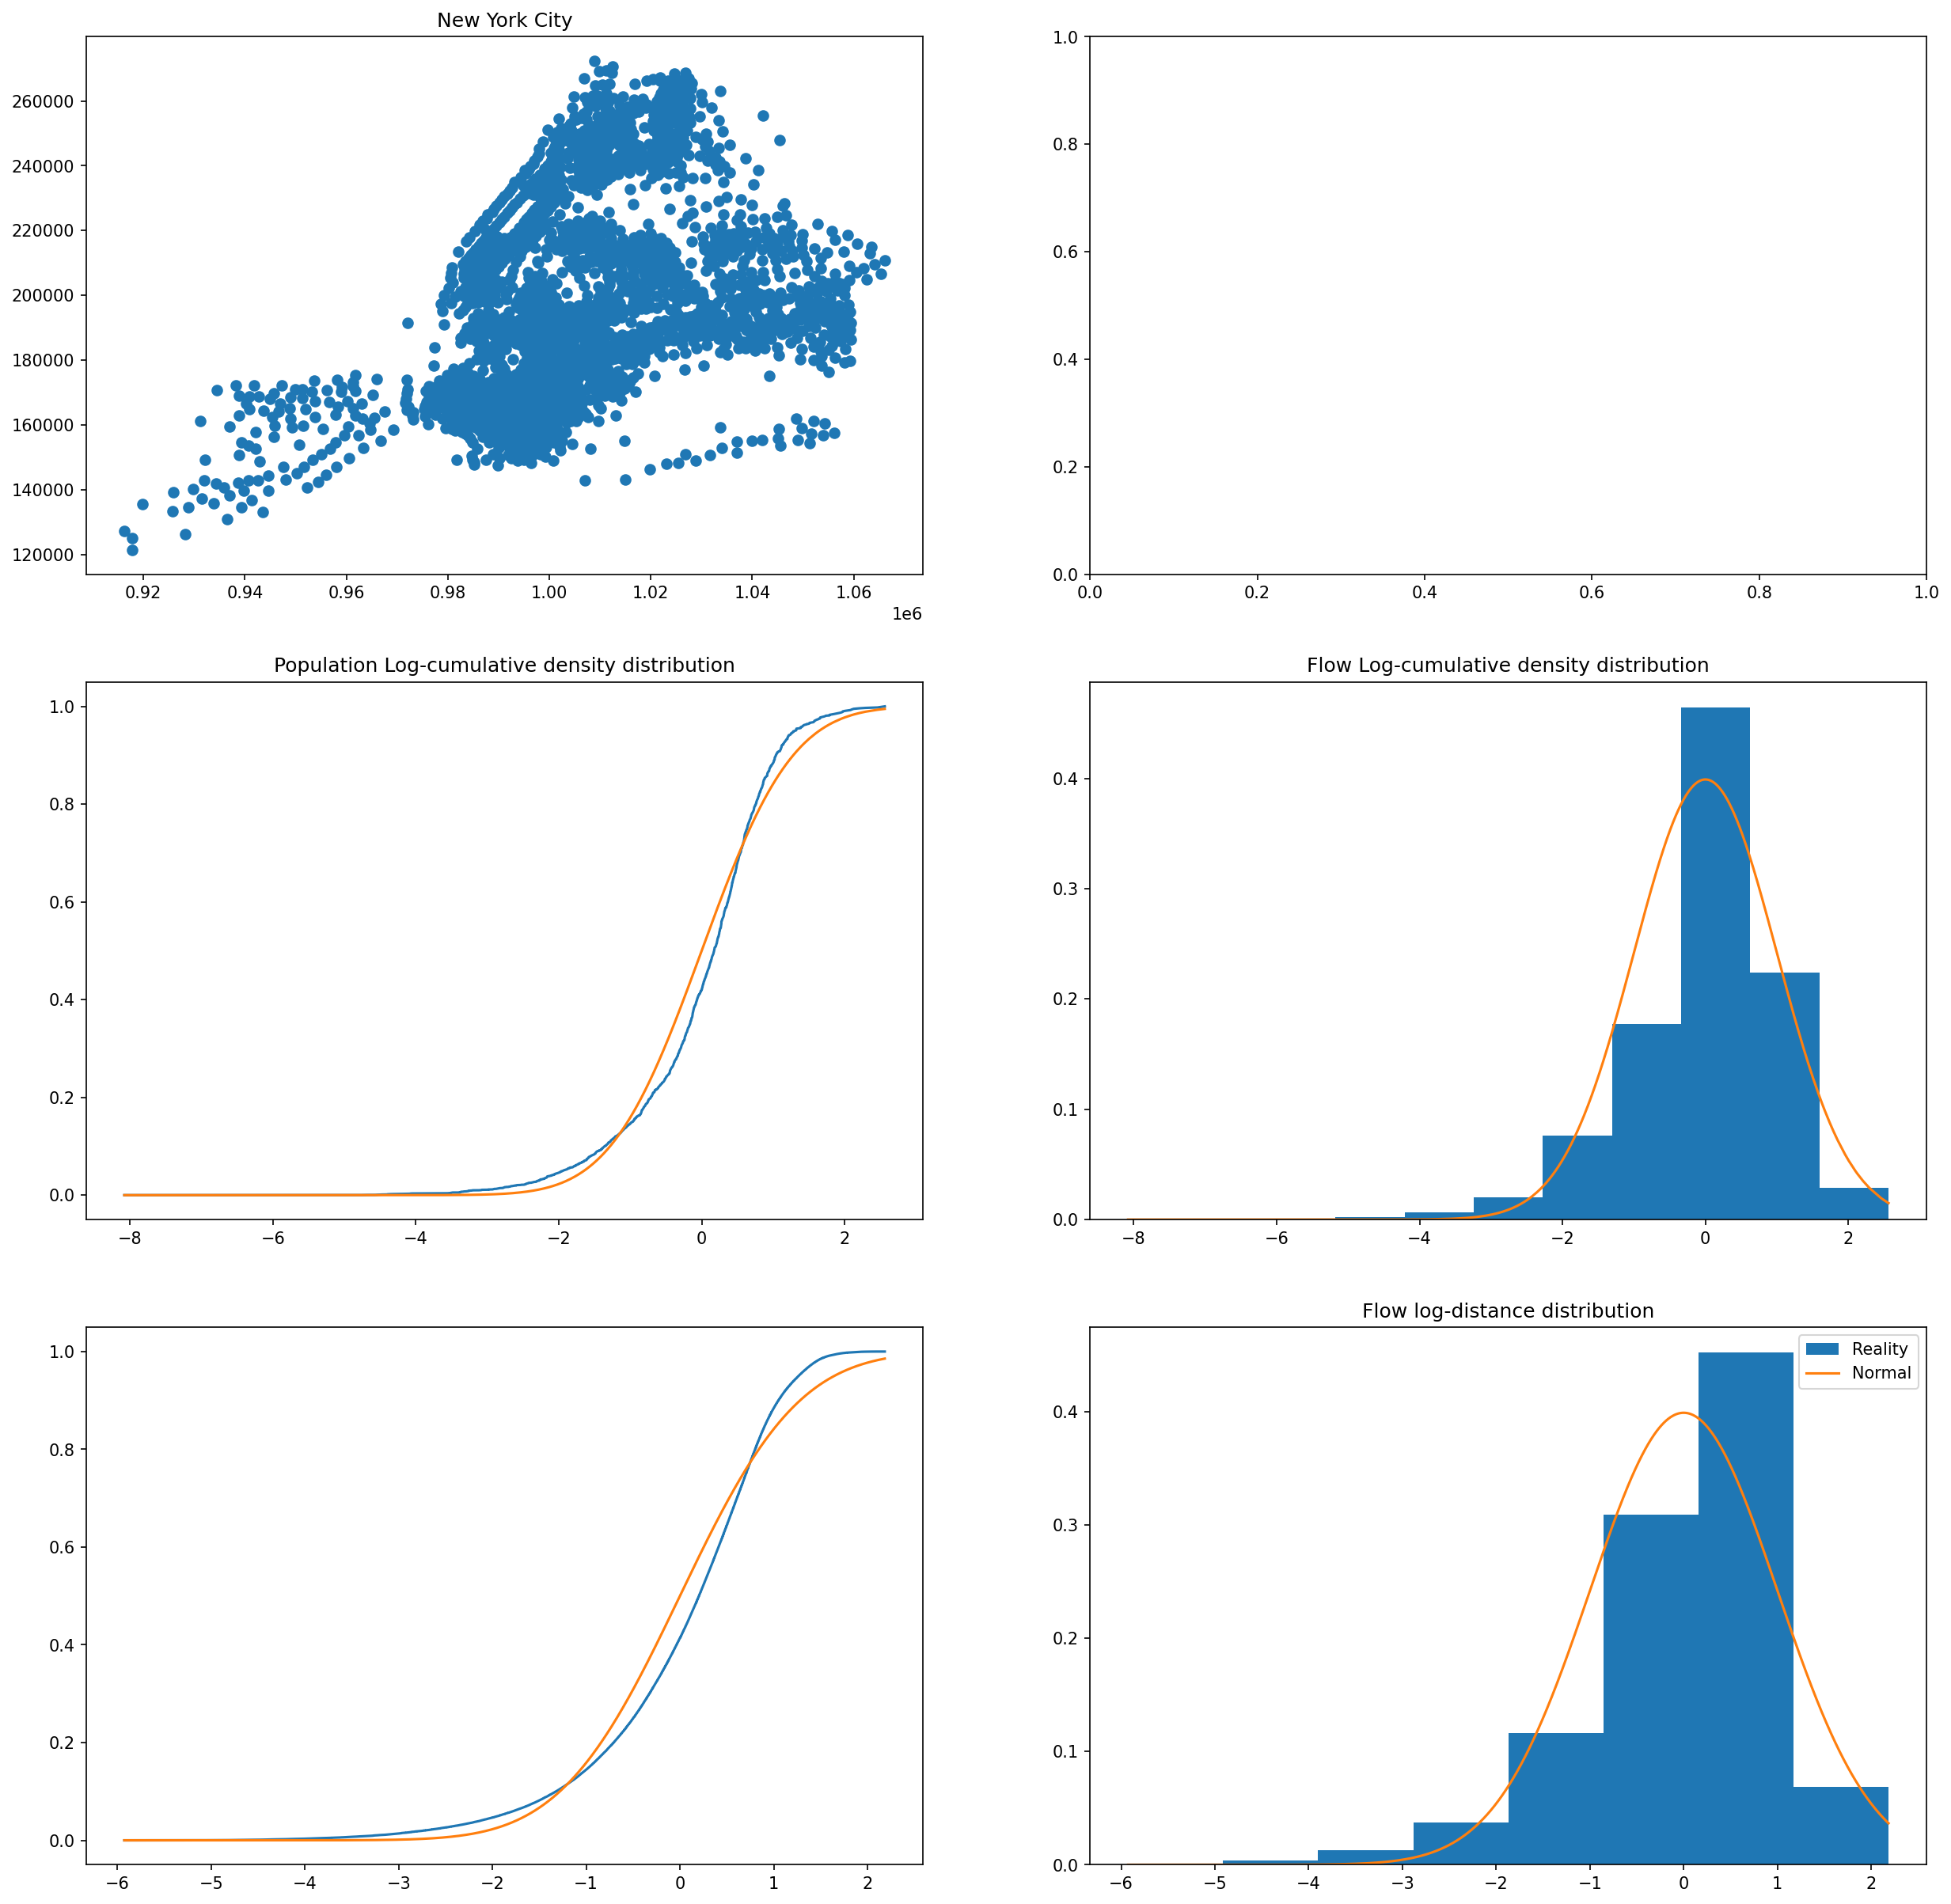

In [6]:
analyzePopDistr(city = city, pop = nodepop,xy = nodexy, flows = A,graphics=True)

New York City, pop_mu = 18.1261, pop_sigma = 1.4156, pop_pv = 0.9839,          flow_mu = -2.0838, flow_sigma = 0.8035, flow_pv = 0.9144


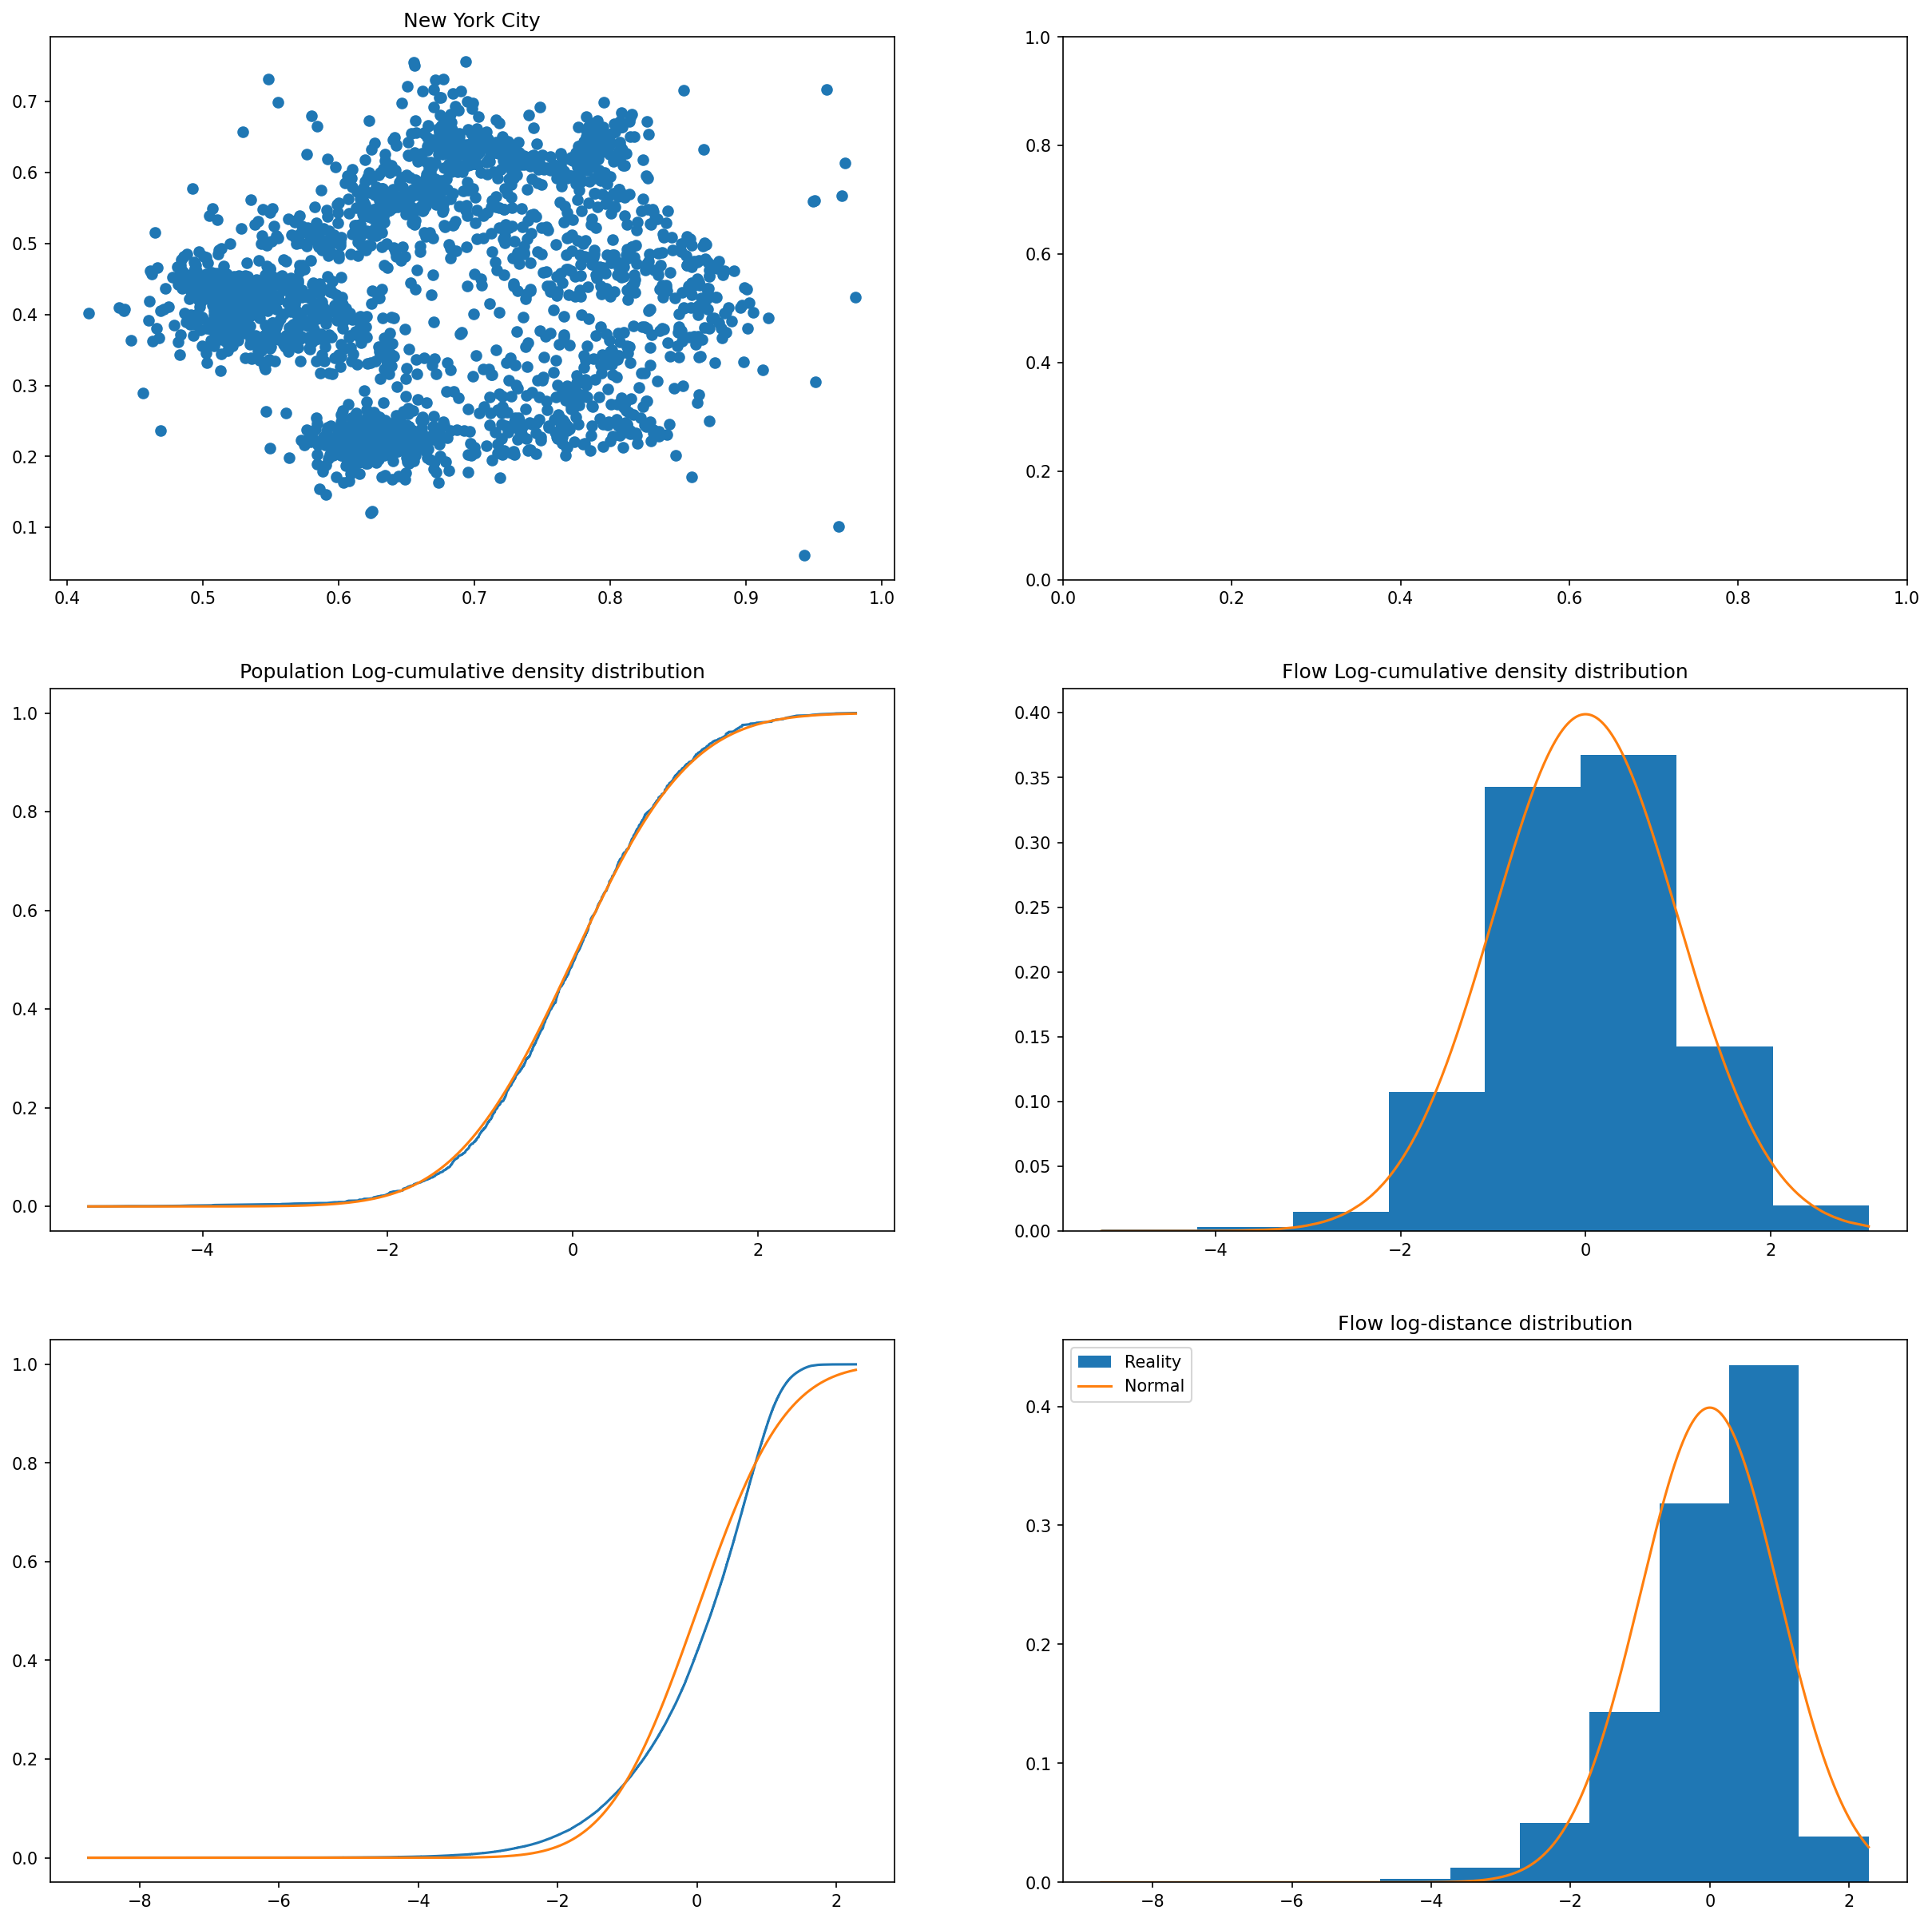

In [44]:
analyzePopDistr(city = city, pop = nodepop,xy = nodesDL, flows = A,graphics=True)

In [21]:
# city = 'Phoenix'
path = 'LEHD/'

cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
#     ('Los Angeles', 'ca', ['Los Angeles County, CA']),
#     ('Chicago', 'il', ['Cook County, IL']),
#     ('Houston', 'tx', ['Harris County, TX']),
#     ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
#     ('Phoenix', 'az', ['Maricopa County, AZ']),
#     ('Philadelphia', 'pa', ['Philadelphia County, PA']),
#     ('San Antonio', 'tx', ['Bexar County, TX']),
#     ('San Diego', 'ca', ['San Diego County, CA']),
#     ('Dallas', 'tx', ['Dallas County, TX']),
#     ('San Jose', 'ca', ['Santa Clara County, CA']),
#     ('Austin', 'tx', ['Travis County, TX']),
]

for city,state, counties in cities:

    if city == 'SF':
        #dataProcessing()
        [G, nodexy] = pickleLoad(path + 'SFnetwork.pkl')
    else:
        print('processing LEHD')
        LEHD = pickleLoad(path + 'LEHD_cities.pkl')
        nodes = pickleLoad(path + 'LEHD_citynode_attributes.pkl')
        CG = LEHD[city]
        nodes = nodes[city]
        G = nx.DiGraph()
        G.add_weighted_edges_from([(e[0], e[1], e[2]['S000']) for e in CG.edges(data = True)])
        nodepop = dict(G.out_degree(weight="weight"))
        nodepop = np.array([nodepop[n] for n in G.nodes()])
#         nodejob = dict(G.in_degree(weight="weight")); nodejob = np.array([nodejob[n] for n in G.nodes()])
#         sx = np.cos(np.pi / 180 * 40);
        nodexy = read_location_from_ct(state,nodes)
        nodearea = read_area_from_ct(state,nodes)


    if not(G is None): #if given a graph G, initialize and run the model
        #main parameters
        mainepochs = 1000
        ed = 2 #node embedding dimensionality
        splitSeed = 10
        seed = 2
        directEmebdding = False #learn node embedding directly or through GNNs

        #define the adjacency matrix
        A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())
#         print(A.shape)
        wind = (A.sum(axis = 0) > 0) & (A.sum(axis = 1) > 0)
        A = A[wind, :][:, wind] #remove nodes with no incoming or outgoing flows
        nodepop = nodepop[wind]
#         nodejob = nodejob[wind]
        nodexy = nodexy[wind]
        nodearea = nodearea[wind]
        n = A.shape[0]
#         print('processing POI')
#         poi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/rxuy-2muj?method=export&format=GeoJSON')
#         ct_map = gpd.read_file('LEHD/'+state+'.zip')
#         nodefts = POIfts(ct_map,poi,list(G.nodes()))
#         nodefts = nodefts[wind]
#         nodefts = torch.FloatTensor(nodefts).to(torch.device("cuda"))
        nodefts = None
        #some basic stats
        print('City {}, Network of size {}, non-zero edges = {}, unique edge values = {}, avg. edge = {}, total network weight = {}'.format(city, len(G), len(G.edges()), len(np.unique(A)), A.mean(), A.sum()))

        analyzePopDistr(city = city, pop = nodepop, xy = nodexy, flows = A,area=nodearea) 
        analyzePopDistr(city = city, pop = nodepop, xy = nodexy, flows = A,area=nodearea) 
        #population and mobility flow distribution analysis

        train, test = getTrainTest(A,train_p= 0.7,  seed = splitSeed) 


        #train-test split for the network edges

        #configurations for the model layers - largely redundant if using directemebdding and exponential attraction
        GNNConfig1 = buildVNNConfig({'out_features': A.shape[0], 'layer_dims':[], 'initSeed': seed}) #A.shape[0]
        GNNConfig2 = buildVNNConfig({'out_features': ed, 'layer_dims':[3 * ed], 'initSeed': seed, 
                                     'actfuncFinal': torch.nn.Sigmoid()}) #2*ed
        VNNConfig = buildVNNConfig({'layer_dims':[4*ed, 2*ed, ed, 3], 'dropout': 0.33, 
                                    'initSeed': seed, 'actfuncFinal': nnExp()}) #nnSquare()
        # input facility_t features here
        NRL = GMLearning(A, nodefts, [GNNConfig1, GNNConfig2], VNNConfig, train, directembedding = directEmebdding) #do we need to eliminate train here?
        NRL.initW(A)
        NRL = NRL.cuda()
        #null model baseline performance
        NRL.lossType = 'logMSE'; print('Baseline logMSE train/test = {}/{}'.\
                                       format(round(NRL.evaluate(X=nodefts,mask = train, baseline = True),3), 
                                            round(NRL.evaluate(X=nodefts,mask = test, baseline = True),3)))
        NRL.lossType = 'binB1'; print('Baseline log-likelihood train/test = {}/{}'.\
                                      format(
                                        round(NRL.evaluate(X=nodefts,mask = train, baseline = True),3), 
                                        round(NRL.evaluate(X=nodefts,mask = test, baseline = True),3)))
        if directEmebdding: #embedding initialization possible only in direct embedding mode
            #singly constrained exponential gravity baseline
            NRL.initEmbed(x = expandToDim(nodexy, d = ed, sigmaScale = 0))
            NRL.lossType = 'binB1'; NRL.fitGamma(mask = train); print('Best gamma = {:.4f}'.format(NRL.gamma))
            NRL.lossType = 'logMSE'; print('Gravity logMSE train/test = {}/{}'.\
                                           format(round(NRL.evaluate(X=nodefts,mask = train, 
                                                                     baseline = False),3), 
                                                  round(NRL.evaluate(X=nodefts,mask = test, 
                                                                     baseline = False),3)))
            NRL.lossType = 'binB1'; print('Gravity log-likelihood train/test = {}/{}'.\
                                          format(
                                                          round(NRL.evaluate(X=nodefts,mask = train, 
                                                                             baseline = False),3), 
                                                          round(NRL.evaluate(X=nodefts,mask = test, 
                                                                             baseline = False),3)))

            #fit the main model
            NRL.initEmbed(x = expandToDim(nodexy, d = ed, sigmaScale = 0.1))
        else:
            NRL.gamma = 10
        lr = [0.001, 0.0003, 0.0003, 0.001]
        #lr = {'OutVNN': 0.0003, 'GNNLayer0': 0.002, 'GNNLayer1': 0.001, 'default': 0.0003}
        NRL.lossType = 'logMSE' 

        NRL.fit(X=nodefts,n_epochs = mainepochs, batchsize = 0, lr = lr, 
                                         interim_output_freq = 50)

        #report the model performance
        NRL.lossType = 'logMSE'; print('Evaluation logMSE train/test = {}/{}'.\
                                       format(round(NRL.evaluate(X=nodefts,mask = train, baseline = False),3), 
                                          round(NRL.evaluate(X=nodefts,mask = test, baseline = False),3)))
        NRL.lossType = 'binB1'; print('Evaluation log-likelihood train/test = {}/{}'.\
                                      format(round(NRL.evaluate(X=nodefts,mask = train, baseline = False),3), 
                                             round(NRL.evaluate(X=nodefts,mask = test, baseline = False),3)))

        nodesDL = NRL.embed(nodefts).cpu().detach().numpy()
        analyzePopDistr(city = city, pop = nodepop,xy = nodesDL, flows = A)
        print('pop geary C on lat lon and embedding  = {}/{}'.format(
                                round(spatialDistribution(nodexy,nodepop)[0],3),
            round(spatialDistribution(nodesDL,nodepop)[0],3)))

        print('pop moran I on lat lon and embedding  = {}/{}'.format(
            round(spatialDistribution(nodexy,nodepop)[2],3),
                                 round(spatialDistribution(nodesDL,nodepop)[2],3)))

processing LEHD


/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City New York City, Network of size 2157, non-zero edges = 976832, unique edge values = 231, avg. edge = 0.7005281926880186, total network weight = 3235180.0
New York City, pop_mu = -4.9815, pop_sigma = 0.9473, pop_pv = 0.8967,          flow_mu = 43814.1733, flow_sigma = 26166.8305, flow_pv = 0.9530
New York City, pop_mu = -4.9815, pop_sigma = 0.9473, pop_pv = 0.8967,          flow_mu = 43814.1733, flow_sigma = 26166.8305, flow_pv = 0.9530
Baseline logMSE train/test = 0.165/0.165
Baseline log-likelihood train/test = 6.028/5.185
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.16536544 full loss: 0.16536544 best loss: 0.16536544 time elapsed: 0.0262s {'OutVNN': 0.0, 'GNNLayer0': 2.0074261443841577e-08, 'GNNLayer1': 8.68881240993863e-08}
Epoch: 0051 of 1000 batch loss: 0.14977649 full loss: 0.15099832 best loss: 0.15099832 time elapsed: 0.6616s {'OutVNN': 0.0, 'GNNLayer0': 5.677128983227607e-05, 'GNNLayer1': 8.300774101050959e-05}
Epoch: 0101 of 1000 batch loss: 0.14307888 full lo

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Los Angeles, Network of size 2341, non-zero edges = 1171362, unique edge values = 246, avg. edge = 0.6562218683106555, total network weight = 3590138.0
Los Angeles, pop_mu = -6.5746, pop_sigma = 1.1363, pop_pv = 0.9245,          flow_mu = 97894.5051, flow_sigma = 65981.7776, flow_pv = 0.9311
Los Angeles, pop_mu = -6.5746, pop_sigma = 1.1363, pop_pv = 0.9245,          flow_mu = 97894.5051, flow_sigma = 65981.7776, flow_pv = 0.9311
Baseline logMSE train/test = 0.213/0.213
Baseline log-likelihood train/test = 6.4/5.558
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.21252489 full loss: 0.21252489 best loss: 0.21252489 time elapsed: 0.0334s {'OutVNN': 0.0, 'GNNLayer0': 2.4559589350127816e-08, 'GNNLayer1': 8.745025743097494e-08}
Epoch: 0051 of 1000 batch loss: 0.18774766 full loss: 0.19006032 best loss: 0.19006032 time elapsed: 0.8388s {'OutVNN': 0.0, 'GNNLayer0': 6.443523118378897e-05, 'GNNLayer1': 8.074810374623768e-05}
Epoch: 0101 of 1000 batch loss: 0.17708270 full loss: 0.

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Chicago, Network of size 1318, non-zero edges = 439553, unique edge values = 459, avg. edge = 1.0727302693403113, total network weight = 1854992.0
Chicago, pop_mu = -6.4362, pop_sigma = 1.1586, pop_pv = 0.9557,          flow_mu = 77599.4865, flow_sigma = 51680.4449, flow_pv = 0.9324
Chicago, pop_mu = -6.4362, pop_sigma = 1.1586, pop_pv = 0.9557,          flow_mu = 77599.4865, flow_sigma = 51680.4449, flow_pv = 0.9324
Baseline logMSE train/test = 0.255/0.255
Baseline log-likelihood train/test = 5.334/4.529
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.25485349 full loss: 0.25485349 best loss: 0.25485349 time elapsed: 0.0055s {'OutVNN': 0.0, 'GNNLayer0': 5.209812905521626e-08, 'GNNLayer1': 8.910260537164033e-08}
Epoch: 0051 of 1000 batch loss: 0.22523162 full loss: 0.22901873 best loss: 0.22901873 time elapsed: 0.1674s {'OutVNN': 0.0, 'GNNLayer0': 9.643615629888893e-05, 'GNNLayer1': 9.66885895433956e-05}
Epoch: 0101 of 1000 batch loss: 0.21053064 full loss: 0.21053064 best

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Houston, Network of size 786, non-zero edges = 290496, unique edge values = 348, avg. edge = 2.5043250522826304, total network weight = 1547162.0
Houston, pop_mu = -7.1979, pop_sigma = 1.1250, pop_pv = 0.9394,          flow_mu = 90703.5309, flow_sigma = 52632.7052, flow_pv = 0.9583
Houston, pop_mu = -7.1979, pop_sigma = 1.1250, pop_pv = 0.9394,          flow_mu = 90703.5309, flow_sigma = 52632.7052, flow_pv = 0.9583
Baseline logMSE train/test = 0.434/0.436
Baseline log-likelihood train/test = 5.416/4.587
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.43361953 full loss: 0.43361953 best loss: 0.43361953 time elapsed: 0.0025s {'OutVNN': 0.0, 'GNNLayer0': 7.600263418969649e-08, 'GNNLayer1': 8.955198948912424e-08}
Epoch: 0051 of 1000 batch loss: 0.38302183 full loss: 0.39007607 best loss: 0.39007607 time elapsed: 0.0721s {'OutVNN': 0.0, 'GNNLayer0': 9.738239296681105e-05, 'GNNLayer1': 0.00010849361182273377}
Epoch: 0101 of 1000 batch loss: 0.36206564 full loss: 0.36206564 bes

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Boston, Network of size 520, non-zero edges = 127357, unique edge values = 278, avg. edge = 3.528264337144646, total network weight = 946718.0
Boston, pop_mu = -6.6354, pop_sigma = 1.5108, pop_pv = 0.9265,          flow_mu = 57711.7004, flow_sigma = 48507.0941, flow_pv = 0.8593
Boston, pop_mu = -6.6354, pop_sigma = 1.5108, pop_pv = 0.9265,          flow_mu = 57711.7004, flow_sigma = 48507.0941, flow_pv = 0.8593
Baseline logMSE train/test = 0.566/0.565
Baseline log-likelihood train/test = 4.93/4.118
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.56554818 full loss: 0.56554818 best loss: 0.56554818 time elapsed: 0.0021s {'OutVNN': 0.0, 'GNNLayer0': 8.333575843072178e-08, 'GNNLayer1': 8.979449253830166e-08}
Epoch: 0051 of 1000 batch loss: 0.48693171 full loss: 0.49644616 best loss: 0.49644616 time elapsed: 0.0556s {'OutVNN': 0.0, 'GNNLayer0': 0.00015115306275584914, 'GNNLayer1': 0.00013922453306850635}
Epoch: 0101 of 1000 batch loss: 0.44831765 full loss: 0.44831765 best los

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Phoenix, Network of size 916, non-zero edges = 349894, unique edge values = 226, avg. edge = 2.118912790473992, total network weight = 1762393.0
Phoenix, pop_mu = -7.3466, pop_sigma = 1.1861, pop_pv = 0.8706,          flow_mu = 98266.8374, flow_sigma = 65766.0878, flow_pv = 0.9309
Phoenix, pop_mu = -7.3466, pop_sigma = 1.1861, pop_pv = 0.8706,          flow_mu = 98266.8374, flow_sigma = 65766.0878, flow_pv = 0.9309
Baseline logMSE train/test = 0.358/0.355
Baseline log-likelihood train/test = 5.509/4.653
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.35784110 full loss: 0.35784110 best loss: 0.35784110 time elapsed: 0.0029s {'OutVNN': 0.0, 'GNNLayer0': 6.920093487414218e-08, 'GNNLayer1': 8.937866790589306e-08}
Epoch: 0051 of 1000 batch loss: 0.32191262 full loss: 0.32632601 best loss: 0.32632601 time elapsed: 0.0884s {'OutVNN': 0.0, 'GNNLayer0': 9.473440204645108e-05, 'GNNLayer1': 0.00010617022934472983}
Epoch: 0101 of 1000 batch loss: 0.30105379 full loss: 0.30105379 best

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Philadelphia, Network of size 384, non-zero edges = 68119, unique edge values = 200, avg. edge = 2.586656122817662, total network weight = 379434.0
Philadelphia, pop_mu = -6.3774, pop_sigma = 0.8483, pop_pv = 0.9364,          flow_mu = 32543.8646, flow_sigma = 19762.1832, flow_pv = 0.9448
Philadelphia, pop_mu = -6.3774, pop_sigma = 0.8483, pop_pv = 0.9364,          flow_mu = 32543.8646, flow_sigma = 19762.1832, flow_pv = 0.9448
Baseline logMSE train/test = 0.362/0.366
Baseline log-likelihood train/test = 4.453/3.649
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.36139333 full loss: 0.36139333 best loss: 0.36139333 time elapsed: 0.0017s {'OutVNN': 0.0, 'GNNLayer0': 8.22839351225989e-08, 'GNNLayer1': 8.98066272294733e-08}
Epoch: 0051 of 1000 batch loss: 0.32482126 full loss: 0.33018318 best loss: 0.33018318 time elapsed: 0.0483s {'OutVNN': 0.0, 'GNNLayer0': 0.00014685594332069143, 'GNNLayer1': 0.000143620002374104}
Epoch: 0101 of 1000 batch loss: 0.30122519 full loss: 0.301

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City San Antonio, Network of size 366, non-zero edges = 83192, unique edge values = 243, avg. edge = 4.825458881777563, total network weight = 639354.0
San Antonio, pop_mu = -7.5995, pop_sigma = 1.1050, pop_pv = 0.8654,          flow_mu = 61295.4883, flow_sigma = 33553.0871, flow_pv = 0.9666
San Antonio, pop_mu = -7.5995, pop_sigma = 1.1050, pop_pv = 0.8654,          flow_mu = 61295.4883, flow_sigma = 33553.0871, flow_pv = 0.9666
Baseline logMSE train/test = 0.411/0.411
Baseline log-likelihood train/test = 4.701/3.846
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.41043141 full loss: 0.41043141 best loss: 0.41043141 time elapsed: 0.0017s {'OutVNN': 0.0, 'GNNLayer0': 8.449716094382306e-08, 'GNNLayer1': 8.979300552642331e-08}
Epoch: 0051 of 1000 batch loss: 0.37328935 full loss: 0.37849677 best loss: 0.37849677 time elapsed: 0.0449s {'OutVNN': 0.0, 'GNNLayer0': 0.00014497610122386276, 'GNNLayer1': 0.0001497488626079007}
Epoch: 0101 of 1000 batch loss: 0.35128820 full loss: 0.351

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City San Diego, Network of size 627, non-zero edges = 180781, unique edge values = 330, avg. edge = 2.983637681307352, total network weight = 1169216.0
San Diego, pop_mu = -7.1565, pop_sigma = 1.3594, pop_pv = 0.8851,          flow_mu = 93057.3944, flow_sigma = 65194.9821, flow_pv = 0.9098
San Diego, pop_mu = -7.1565, pop_sigma = 1.3594, pop_pv = 0.8851,          flow_mu = 93057.3944, flow_sigma = 65194.9821, flow_pv = 0.9098
Baseline logMSE train/test = 0.51/0.509
Baseline log-likelihood train/test = 5.002/4.15
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.50921112 full loss: 0.50921112 best loss: 0.50921112 time elapsed: 0.0020s {'OutVNN': 0.0, 'GNNLayer0': 8.13792618955054e-08, 'GNNLayer1': 8.970698277249763e-08}
Epoch: 0051 of 1000 batch loss: 0.44295862 full loss: 0.45243651 best loss: 0.45243651 time elapsed: 0.0603s {'OutVNN': 0.0, 'GNNLayer0': 0.00013043225151656706, 'GNNLayer1': 0.00012875003419483884}
Epoch: 0101 of 1000 batch loss: 0.40329683 full loss: 0.40329683 

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Dallas, Network of size 529, non-zero edges = 129352, unique edge values = 255, avg. edge = 2.838168817292677, total network weight = 794236.0
Dallas, pop_mu = -7.3638, pop_sigma = 0.9938, pop_pv = 0.9505,          flow_mu = 64081.8127, flow_sigma = 34759.6856, flow_pv = 0.9674
Dallas, pop_mu = -7.3638, pop_sigma = 0.9938, pop_pv = 0.9505,          flow_mu = 64081.8127, flow_sigma = 34759.6856, flow_pv = 0.9674
Baseline logMSE train/test = 0.391/0.39
Baseline log-likelihood train/test = 4.788/3.95
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.39100683 full loss: 0.39100683 best loss: 0.39100683 time elapsed: 0.0021s {'OutVNN': 0.0, 'GNNLayer0': 7.863189269239238e-08, 'GNNLayer1': 8.964304617415565e-08}
Epoch: 0051 of 1000 batch loss: 0.35389546 full loss: 0.35840628 best loss: 0.35840628 time elapsed: 0.0673s {'OutVNN': 0.0, 'GNNLayer0': 0.0001233563162964827, 'GNNLayer1': 0.0001369454324611501}
Epoch: 0101 of 1000 batch loss: 0.33633387 full loss: 0.33633387 best loss: 

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City San Jose, Network of size 372, non-zero edges = 81938, unique edge values = 264, avg. edge = 4.730994912706671, total network weight = 654694.0
San Jose, pop_mu = -6.9162, pop_sigma = 1.0611, pop_pv = 0.8476,          flow_mu = 49464.8530, flow_sigma = 37873.0283, flow_pv = 0.8927
San Jose, pop_mu = -6.9162, pop_sigma = 1.0611, pop_pv = 0.8476,          flow_mu = 49464.8530, flow_sigma = 37873.0283, flow_pv = 0.8927
Baseline logMSE train/test = 0.485/0.487
Baseline log-likelihood train/test = 4.517/3.682
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.48400098 full loss: 0.48400098 best loss: 0.48400098 time elapsed: 0.0031s {'OutVNN': 0.0, 'GNNLayer0': 8.527390730899322e-08, 'GNNLayer1': 8.987523865536159e-08}
Epoch: 0051 of 1000 batch loss: 0.42666799 full loss: 0.43640971 best loss: 0.43640971 time elapsed: 0.0512s {'OutVNN': 0.0, 'GNNLayer0': 0.0001423185921583769, 'GNNLayer1': 0.00015082757786331059}
Epoch: 0101 of 1000 batch loss: 0.37815940 full loss: 0.37815940 bes

/tmp/ipykernel_2685877/184516870.py:49: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = 1.0 * np.array(nx.adjacency_matrix(G,sorted(list(G.nodes()))).todense())


City Austin, Network of size 218, non-zero edges = 34777, unique edge values = 296, avg. edge = 8.712140839686551, total network weight = 410246.0
Austin, pop_mu = -7.5470, pop_sigma = 1.3099, pop_pv = 0.8743,          flow_mu = 47506.7763, flow_sigma = 30492.1609, flow_pv = 0.9405
Austin, pop_mu = -7.5470, pop_sigma = 1.3099, pop_pv = 0.8743,          flow_mu = 47506.7763, flow_sigma = 30492.1609, flow_pv = 0.9405
Baseline logMSE train/test = 0.542/0.541
Baseline log-likelihood train/test = 4.188/3.311
Optimization starting
Epoch: 0001 of 1000 batch loss: 0.54107189 full loss: 0.54107189 best loss: 0.54107189 time elapsed: 0.0015s {'OutVNN': 0.0, 'GNNLayer0': 8.801399923970228e-08, 'GNNLayer1': 8.991402323859295e-08}
Epoch: 0051 of 1000 batch loss: 0.49074987 full loss: 0.49722314 best loss: 0.49722314 time elapsed: 0.0415s {'OutVNN': 0.0, 'GNNLayer0': 0.00017481829141385903, 'GNNLayer1': 0.0001615209034680029}
Epoch: 0101 of 1000 batch loss: 0.46478957 full loss: 0.46478957 best loss

Austin, pop_mu = -9.8055, pop_sigma = 1.2113, pop_pv = 0.8760,          flow_mu = 47506.7763, flow_sigma = 30492.1609, flow_pv = 0.9405


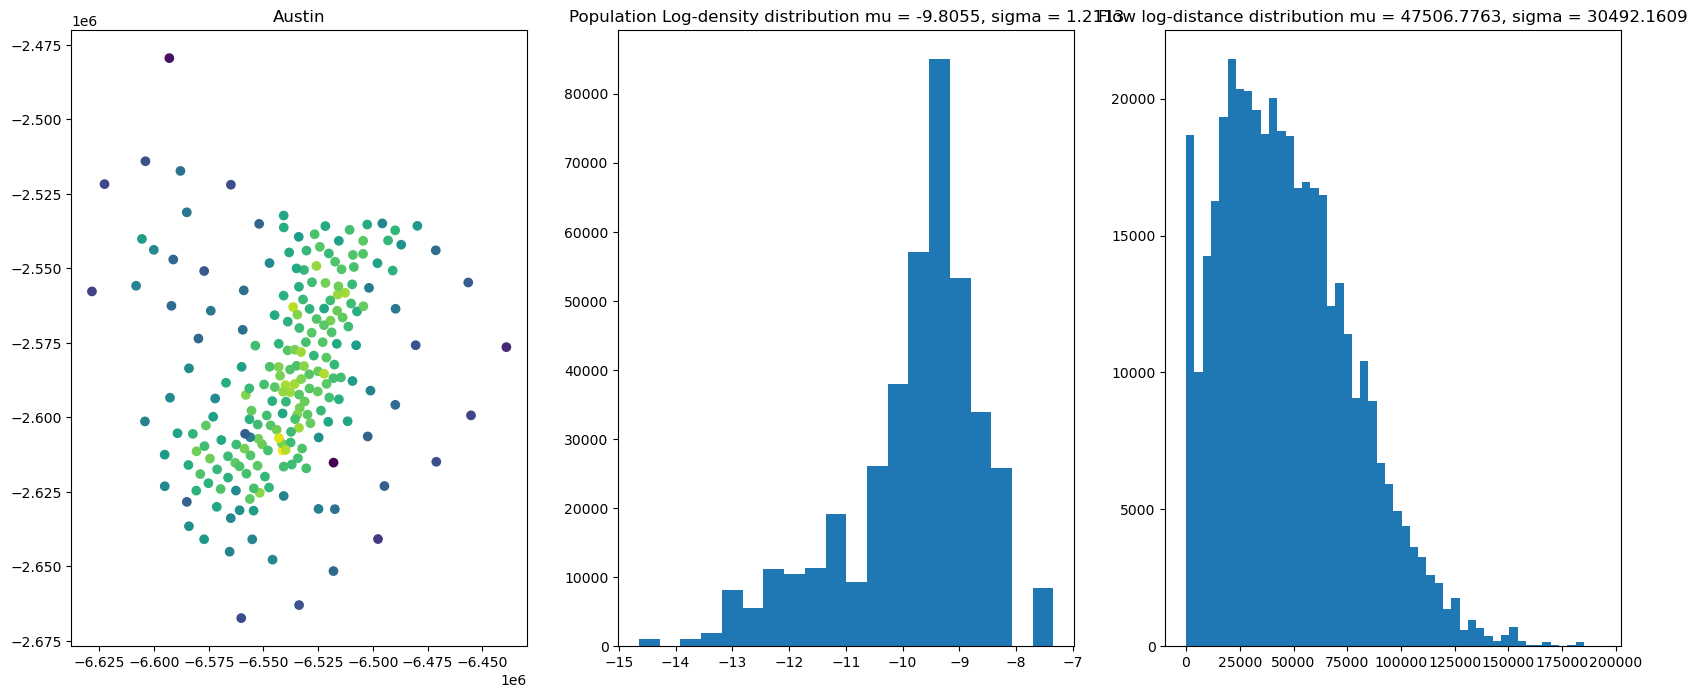

In [24]:
analyzePopDistr(city = city, pop = nodepop,xy = nodexy, flows = A,graphics=True)

Austin, pop_mu = 16.1606, pop_sigma = 1.1192, pop_pv = 0.9573,          flow_mu = 0.1458, flow_sigma = 0.0858, flow_pv = 0.9555


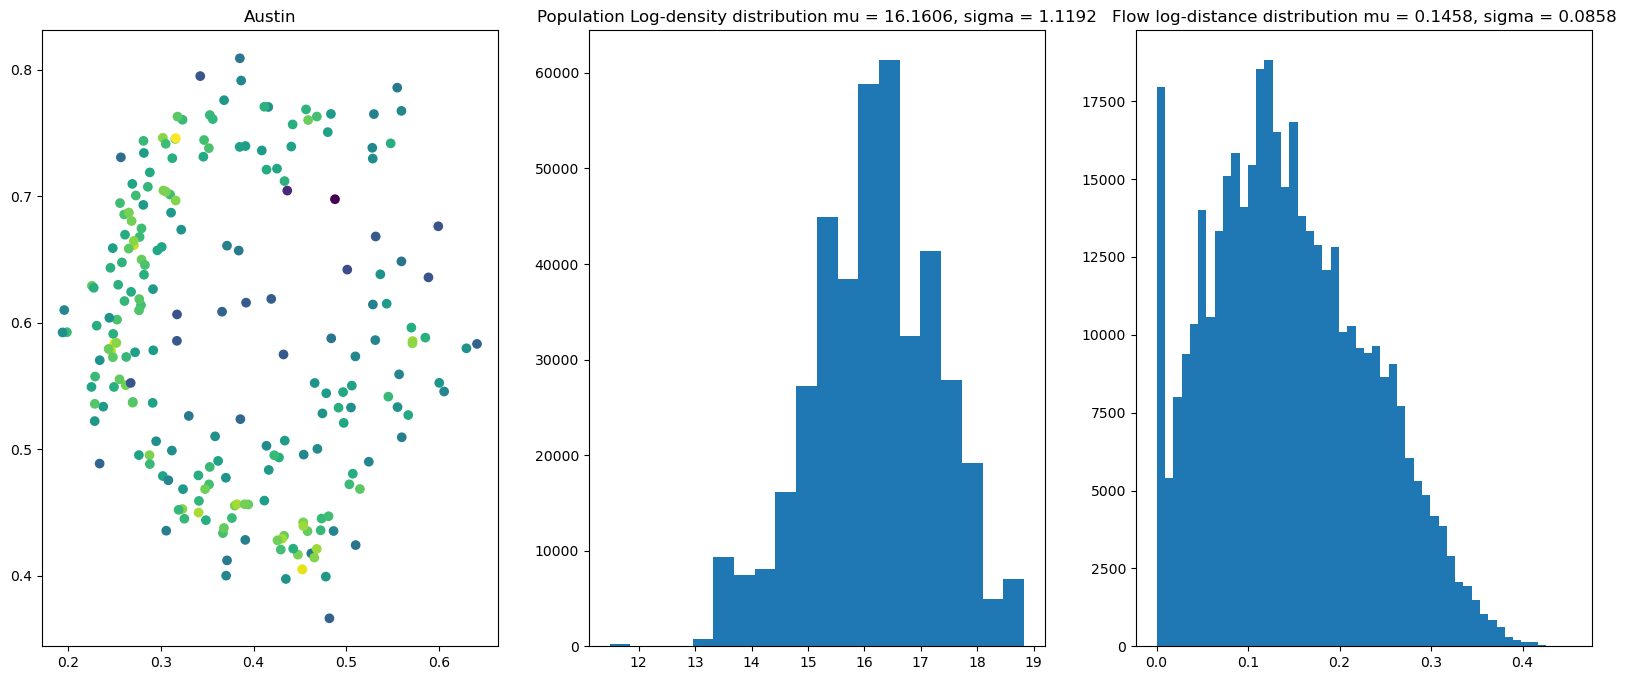

In [22]:
analyzePopDistr(city = city, pop = nodepop,xy = nodesDL, flows = A,graphics=True)